# Flight Delay - Explainable AI
Work developed by :
- Francisco Tavares
- Rodrigo Batista
- Rodrigo Taveira

# Table of Contents
- [Introduction](#introduction)
- [Task 1: Pre-Modelling Explanations](#task-1-pre-modelling-explanations)
- [Task 2: In-Modeling Explanations](#task-2-in-modeling-explanations)
- [Task 3: Post-Modeling Explanations](#task-3-post-modelling-explanations)
    - [Task 3.1: Simplification-Based Technique](#task-31---simplification-based-technique)
    - [Task 3.2: Featured-Based Techniques](#task-32---feature-based-techniques)
    - [Task 3.3: Example-Based Technique](#task-33---example-based-technique)
- [Task 4: Quality of Explanations](#task-4-quality-of-explanations)
- [Conclusion](#conclusion)

# Introduction
[Back to the top](#Table-of-Contents)

Flight delays are a persistent challenge in the aviation industry, affecting passengers, airlines, and airport operations. Although machine learning models have shown promising results in delay prediction, predictive performance alone is often insufficient for real-world adoption. In operational settings, understanding the reasons behind model predictions is essential to support trust, validation, and decision-making, a need addressed by Explainable Artificial Intelligence (XAI).

In this work, we study a binary classification task for flight delay prediction using structured tabular data that combines operational flight information with weather and geolocation features. This allows the analysis of heterogeneous factors such as airline, departure time period, aircraft characteristics, and meteorological conditions, providing a realistic testbed for XAI techniques applied to tabular models.

The objective of this project is to compare how different XAI techniques explain model behaviour across multiple stages of the modelling pipeline. Pre-modelling explanations are explored through exploratory analysis, in-modelling explanations are obtained using a glass-box Decision Tree, and post-hoc explanation methods are applied to a Random Forest model. Rather than focusing on methodological details, we emphasise a comparative analysis of the insights and limitations of each approach in a real-world prediction scenario.

### Library Dependencies

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error, r2_score, pairwise_distances
from sklearn import tree as sktree
from IPython.display import HTML, display
import dice_ml
from dice_ml.utils import helpers
import shap

/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Task 1: Pre-Modelling Explanations
[Back to the top](#Table-of-Contents)

Before developing any predictive model, it is essential to understand the structure, quality, and behaviour of the data. In this phase, the dataset will be explored to identify relevant patterns, relationships, and potential sources of bias that may influence flight delay predictions. Through descriptive statistics and visual analysis, we aim to gain an initial understanding of how different variables(such as airline, day of the week, departure time, and flight distance) relate to delays. This exploratory stage provides the foundation for informed modelling decisions, ensuring that the subsequent analysis is guided by a clear comprehension of the data and its underlying dynamics.

In [3]:
file_path = "dataset/US_flights_2023.csv"  
flights = pd.read_csv(file_path)
flights

FlightDate  Day_Of_Week          Airline Tail_Number Dep_Airport  \
0        2023-01-02            1     Endeavor Air      N605LR         BDL   
1        2023-01-03            2     Endeavor Air      N605LR         BDL   
2        2023-01-04            3     Endeavor Air      N331PQ         BDL   
3        2023-01-05            4     Endeavor Air      N906XJ         BDL   
4        2023-01-06            5     Endeavor Air      N337PQ         BDL   
...             ...          ...              ...         ...         ...   
6743399  2023-12-31            7  JetBlue Airways      N903JB         SJU   
6743400  2023-12-31            7  JetBlue Airways      N535JB         MCO   
6743401  2023-12-31            7  JetBlue Airways      N354JB         PHL   
6743402  2023-12-31            7  JetBlue Airways      N768JB         PBI   
6743403  2023-12-31            7  JetBlue Airways      N547JB         BDL   

                           Dep_CityName DepTime_label  Dep_Delay  \
0                          Hartford, CT       Morning         -3   
1                          Hartford, CT       Morning         -5   
2                          Hartford, CT       Morning         -5   
3                          Hartford, CT       Morning         -6   
4                          Hartford, CT       Morning         -1   
...                                 ...           ...        ...   
6743399                    San Juan, PR       Morning          4   
6743400                     Orlando, FL       Evening        113   
6743401                Philadelphia, PA     Afternoon        -11   
6743402  West Palm Beach/Palm Beach, FL     Afternoon         -7   
6743403                    Hartford, CT       Morning         -8   

         Dep_Delay_Tag Dep_Delay_Type  ... Flight_Duration  \
0                    0      Low <5min  ...              56   
1                    0      Low <5min  ...              62   
2                    0      Low <5min  ...              49   
3                    0      Low <5min  ...              54   
4                    0      Low <5min  ...              50   
...                ...            ...  ...             ...   
6743399              1      Low <5min  ...             219   
6743400              1   Hight >60min  ...             162   
6743401              0      Low <5min  ...              73   
6743402              0      Low <5min  ...             158   
6743403              0      Low <5min  ...             173   

               Distance_type  Delay_Carrier Delay_Weather  Delay_NAS  \
0         Short Haul >1500Mi              0             0          0   
1         Short Haul >1500Mi              0             0          0   
2         Short Haul >1500Mi              0             0          0   
3         Short Haul >1500Mi              0             0          0   
4         Short Haul >1500Mi              0             0          0   
...                      ...            ...           ...        ...   
6743399  Medium Haul <3000Mi              0             0          0   
6743400   Short Haul >1500Mi              4             0          0   
6743401   Short Haul >1500Mi              0             0          0   
6743402   Short Haul >1500Mi              0             0          0   
6743403   Short Haul >1500Mi              0             0          0   

        Delay_Security  Delay_LastAircraft           Manufacturer    Model  \
0                    0                   0  CANADAIR REGIONAL JET      CRJ   
1                    0                   0  CANADAIR REGIONAL JET      CRJ   
2                    0                   0  CANADAIR REGIONAL JET      CRJ   
3                    0                   0  CANADAIR REGIONAL JET      CRJ   
4                    0                   0  CANADAIR REGIONAL JET      CRJ   
...                ...                 ...                    ...      ...   
6743399              0                   0                 AIRBUS     A321   
6743400              0           

We will check whether there are duplicated records, i.e., whether the same airport has multiple entries for the same day. If there aren’t, we proceed to the merge.

In [4]:
weather = pd.read_csv("dataset/weather_meteo_by_airport.csv")

weather[["time", "airport_id"]].duplicated().sum()

np.int64(0)

In [5]:
df = pd.merge(
    flights,
    weather,
    left_on=["FlightDate", "Dep_Airport"],
    right_on=["time", "airport_id"],
    how="left"
).drop(columns=["time", "airport_id"])

df

FlightDate  Day_Of_Week          Airline Tail_Number Dep_Airport  \
0        2023-01-02            1     Endeavor Air      N605LR         BDL   
1        2023-01-03            2     Endeavor Air      N605LR         BDL   
2        2023-01-04            3     Endeavor Air      N331PQ         BDL   
3        2023-01-05            4     Endeavor Air      N906XJ         BDL   
4        2023-01-06            5     Endeavor Air      N337PQ         BDL   
...             ...          ...              ...         ...         ...   
6743399  2023-12-31            7  JetBlue Airways      N903JB         SJU   
6743400  2023-12-31            7  JetBlue Airways      N535JB         MCO   
6743401  2023-12-31            7  JetBlue Airways      N354JB         PHL   
6743402  2023-12-31            7  JetBlue Airways      N768JB         PBI   
6743403  2023-12-31            7  JetBlue Airways      N547JB         BDL   

                           Dep_CityName DepTime_label  Dep_Delay  \
0                          Hartford, CT       Morning         -3   
1                          Hartford, CT       Morning         -5   
2                          Hartford, CT       Morning         -5   
3                          Hartford, CT       Morning         -6   
4                          Hartford, CT       Morning         -1   
...                                 ...           ...        ...   
6743399                    San Juan, PR       Morning          4   
6743400                     Orlando, FL       Evening        113   
6743401                Philadelphia, PA     Afternoon        -11   
6743402  West Palm Beach/Palm Beach, FL     Afternoon         -7   
6743403                    Hartford, CT       Morning         -8   

         Dep_Delay_Tag Dep_Delay_Type  ...    Model Aicraft_age  tavg  tmin  \
0                    0      Low <5min  ...      CRJ          16   2.9  -2.1   
1                    0      Low <5min  ...      CRJ          16   1.8  -1.6   
2                    0      Low <5min  ...      CRJ          10   5.2   3.9   
3                    0      Low <5min  ...      CRJ          17   6.8   3.9   
4                    0      Low <5min  ...      CRJ          10   3.3   0.0   
...                ...            ...  ...      ...         ...   ...   ...   
6743399              1      Low <5min  ...     A321          11  25.8  23.9   
6743400              1   Hight >60min  ...     A320          22  12.4   6.1   
6743401              0      Low <5min  ...  190/195          11   6.1   2.8   
6743402              0      Low <5min  ...     A320          15  14.2   8.3   
6743403              0      Low <5min  ...     A320          22   2.7   1.7   

         tmax  prcp  snow   wdir  wspd    pres  
0         8.3   0.0   0.0  338.0   3.2  1019.1  
1         4.4  10.7   0.0    3.0   3.6  1015.2  
2         8.3   6.6   0.0    1.0   7.2  1011.1  
3         7.8   0.8   0.0   14.0  13.7  1014.8  
4         3.9   9.7   0.0    0.0   5.8  1016.1  
...       ...   ...   ...    ...   ...     ...  
6743399  28.3   1.5   0.0   37.0   8.3  1017.8  
6743400  18.9   0.0   0.0  325.0   5.6  1023.8  
6743401   8.3   0.0   0.0  286.0   9.7  1015.5  
6743402  21.1   0.0   0.0  335.0   4.0  1023.3  
6743403   3.9   0.0   0.0  312.0  14.0  1013.3  

[6743404 rows x 32 columns]

After this merge, we obtain a dataset where each row corresponds to a flight and the weather conditions for that airport on that day. Therefore, flights that occurred on the same day and at the same airport share the same meteorological conditions.

In [6]:
geo = pd.read_csv("dataset/airports_geolocation.csv")

print("Duplicated: ", geo["IATA_CODE"].duplicated().sum())

geo.head()

Duplicated:  0


IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447

We merge first with the departure airport 

In [7]:
df = pd.merge(
    df,
    geo,
    left_on="Dep_Airport",
    right_on="IATA_CODE",
    how="left"
)

df = df.rename(columns={
    "AIRPORT": "Dep_Airport_Name",
    "CITY": "Dep_City",
    "STATE": "Dep_State",
    "COUNTRY": "Dep_Country",
    "LATITUDE": "Dep_Latitude",
    "LONGITUDE": "Dep_Longitude"
}).drop(columns=["IATA_CODE"])


And then with the arrival airport 

In [8]:
df = pd.merge(
    df,
    geo,
    left_on="Arr_Airport",
    right_on="IATA_CODE",
    how="left"
)

df = df.rename(columns={
    "AIRPORT": "Arr_Airport_Name",
    "CITY": "Arr_City",
    "STATE": "Arr_State",
    "COUNTRY": "Arr_Country",
    "LATITUDE": "Arr_Latitude",
    "LONGITUDE": "Arr_Longitude"
}).drop(columns=["IATA_CODE"])

df

FlightDate  Day_Of_Week          Airline Tail_Number Dep_Airport  \
0        2023-01-02            1     Endeavor Air      N605LR         BDL   
1        2023-01-03            2     Endeavor Air      N605LR         BDL   
2        2023-01-04            3     Endeavor Air      N331PQ         BDL   
3        2023-01-05            4     Endeavor Air      N906XJ         BDL   
4        2023-01-06            5     Endeavor Air      N337PQ         BDL   
...             ...          ...              ...         ...         ...   
6743399  2023-12-31            7  JetBlue Airways      N903JB         SJU   
6743400  2023-12-31            7  JetBlue Airways      N535JB         MCO   
6743401  2023-12-31            7  JetBlue Airways      N354JB         PHL   
6743402  2023-12-31            7  JetBlue Airways      N768JB         PBI   
6743403  2023-12-31            7  JetBlue Airways      N547JB         BDL   

                           Dep_CityName DepTime_label  Dep_Delay  \
0                          Hartford, CT       Morning         -3   
1                          Hartford, CT       Morning         -5   
2                          Hartford, CT       Morning         -5   
3                          Hartford, CT       Morning         -6   
4                          Hartford, CT       Morning         -1   
...                                 ...           ...        ...   
6743399                    San Juan, PR       Morning          4   
6743400                     Orlando, FL       Evening        113   
6743401                Philadelphia, PA     Afternoon        -11   
6743402  West Palm Beach/Palm Beach, FL     Afternoon         -7   
6743403                    Hartford, CT       Morning         -8   

         Dep_Delay_Tag Dep_Delay_Type  ... Dep_State Dep_Country  \
0                    0      Low <5min  ...        CT         USA   
1                    0      Low <5min  ...        CT         USA   
2                    0      Low <5min  ...        CT         USA   
3                    0      Low <5min  ...        CT         USA   
4                    0      Low <5min  ...        CT         USA   
...                ...            ...  ...       ...         ...   
6743399              1      Low <5min  ...        PR         USA   
6743400              1   Hight >60min  ...        FL         USA   
6743401              0      Low <5min  ...        PA         USA   
6743402              0      Low <5min  ...        FL         USA   
6743403              0      Low <5min  ...        CT         USA   

         Dep_Latitude Dep_Longitude  \
0            41.93887     -72.68323   
1            41.93887     -72.68323   
2            41.93887     -72.68323   
3            41.93887     -72.68323   
4            41.93887     -72.68323   
...               ...           ...   
6743399      18.43942     -66.00183   
6743400      28.42889     -81.31603   
6743401      39.87195     -75.24114   
6743402      26.68316     -80.09559   
6743403      41.93887     -72.68323   

                                          Arr_Airport_Name         Arr_City  \
0                  LaGuardia Airport (Marine Air Terminal)         New York   
1                  LaGuardia Airport (Marine Air Terminal)         New York   
2                  LaGuardia Airport (Marine Air Terminal)         New York   
3                  LaGuardia Airport (Marine Air Terminal)         New York   
4                  LaGuardia Airport (Marine Air Terminal)         New York   
...                                                    ...              ...   
6743399  John F. Kennedy International Airport (New Yor...         New York   
6743400             Luis Muñoz Marín International Airport         San Juan   
6743401   Gen. Edward Lawrence Logan International Airport           Boston   
6743402                      Bradley International Airport    Windsor Locks   
6743403                   Palm Beach International Airport  West Palm Beach   

         Arr_State  Arr_Country 

We can see that the dataset contains around 6 million instances, which leads to high model execution times. To optimize performance and reduce feature variability, we focus on the two main airports (“Hartsfield-Jackson Atlanta International Airport” and “Denver International Airport”).

In [9]:
top_dep = df["Dep_Airport"].value_counts().head(2).index
df_reduced = df[df["Dep_Airport"].isin(top_dep)]
print("Number of instances:", len(df_reduced))
print("Airport:", list(top_dep))

Number of instances: 617135
Airport: ['ATL', 'DEN']


Now lets check if our target class is balanced.

In [10]:
target = 'Dep_Delay_Tag'

print(df_reduced[target].value_counts())
print(df_reduced[target].value_counts(normalize=True))

Dep_Delay_Tag
0    343063
1    274072
Name: count, dtype: int64
Dep_Delay_Tag
0    0.555896
1    0.444104
Name: proportion, dtype: float64


In [11]:
df_reduced.groupby("Dep_Airport")["Dep_Delay_Tag"].value_counts().unstack()

Dep_Delay_Tag       0       1
Dep_Airport                  
ATL            204125  128810
DEN            138938  145262

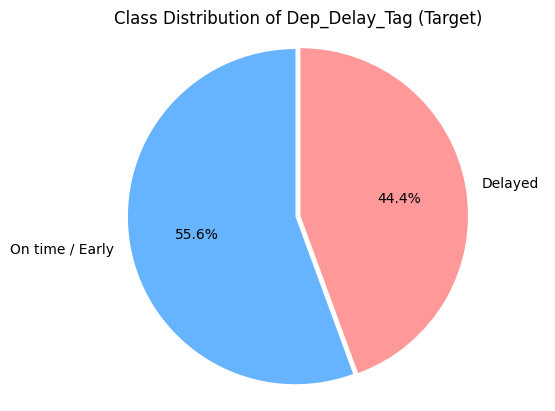

In [12]:
target = 'Dep_Delay_Tag'

contagem = df_reduced[target].value_counts()

plt.pie(
    contagem,
    labels=['On time / Early', 'Delayed'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999'],
    explode=(0.03, 0) 
)
plt.title("Class Distribution of Dep_Delay_Tag (Target)")
plt.axis('equal') 
plt.show()


We can see that is balanced.

Now we will check whether some features can lead to data leakage, namely the "Delay" features.

In [13]:
causes = ["Delay_Carrier", "Delay_Weather", "Delay_NAS", "Delay_Security", "Delay_LastAircraft"]

for col in causes:
    cond = (df_reduced[col] > 0) & (df_reduced["Dep_Delay_Tag"] == 0)
    n = cond.sum()
    print(f"{col}: {n} cases with {col}>0 but arrived on time (Dep_Delay_Tag=0)")
    cond2 = (df_reduced[col] > 0) & (df_reduced["Dep_Delay_Tag"] == 1)
    n2 = cond2.sum()
    print(f"{col}: {n2} cases with {col}>0 but arrived with delay (Dep_Delay_Tag=1)")


Delay_Carrier: 1238 cases with Delay_Carrier>0 but arrived on time (Dep_Delay_Tag=0)
Delay_Carrier: 90846 cases with Delay_Carrier>0 but arrived with delay (Dep_Delay_Tag=1)
Delay_Weather: 1 cases with Delay_Weather>0 but arrived on time (Dep_Delay_Tag=0)
Delay_Weather: 6375 cases with Delay_Weather>0 but arrived with delay (Dep_Delay_Tag=1)
Delay_NAS: 8831 cases with Delay_NAS>0 but arrived on time (Dep_Delay_Tag=0)
Delay_NAS: 49247 cases with Delay_NAS>0 but arrived with delay (Dep_Delay_Tag=1)
Delay_Security: 0 cases with Delay_Security>0 but arrived on time (Dep_Delay_Tag=0)
Delay_Security: 375 cases with Delay_Security>0 but arrived with delay (Dep_Delay_Tag=1)
Delay_LastAircraft: 2 cases with Delay_LastAircraft>0 but arrived on time (Dep_Delay_Tag=0)
Delay_LastAircraft: 64649 cases with Delay_LastAircraft>0 but arrived with delay (Dep_Delay_Tag=1)


As we can see, these features introduce significant data leakage, so we decide to remove all of them from the dataset.

In [14]:
df_clean = df_reduced.drop(columns=["Arr_Delay", "Arr_Delay_Type", "Dep_Delay", "Dep_Delay_Type", "Delay_LastAircraft", "Delay_Security", "Delay_Weather", "Delay_Carrier", "Delay_NAS"])

In [15]:
df_clean.to_csv("reduced_dataset.csv", index=False)

In [16]:
df=pd.read_csv("reduced_dataset.csv")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617135 entries, 0 to 617134
Data columns (total 35 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   FlightDate        617135 non-null  object 
 1   Day_Of_Week       617135 non-null  int64  
 2   Airline           617135 non-null  object 
 3   Tail_Number       617135 non-null  object 
 4   Dep_Airport       617135 non-null  object 
 5   Dep_CityName      617135 non-null  object 
 6   DepTime_label     617135 non-null  object 
 7   Dep_Delay_Tag     617135 non-null  int64  
 8   Arr_Airport       617135 non-null  object 
 9   Arr_CityName      617135 non-null  object 
 10  Flight_Duration   617135 non-null  int64  
 11  Distance_type     617135 non-null  object 
 12  Manufacturer      617135 non-null  object 
 13  Model             617135 non-null  object 
 14  Aicraft_age       617135 non-null  int64  
 15  tavg              617135 non-null  float64
 16  tmin              61

In [17]:
df.describe()

Day_Of_Week  Dep_Delay_Tag  Flight_Duration    Aicraft_age  \
count  617135.000000  617135.000000    617135.000000  617135.000000   
mean        3.979836       0.444104       128.769533      14.935465   
std         2.002224       0.496866        59.773809       8.578684   
min         1.000000       0.000000        23.000000       1.000000   
25%         2.000000       0.000000        89.000000       7.000000   
50%         4.000000       0.000000       118.000000      15.000000   
75%         6.000000       1.000000       150.000000      23.000000   
max         7.000000       1.000000       719.000000      57.000000   

                tavg           tmin           tmax           prcp  \
count  617135.000000  617135.000000  617135.000000  617135.000000   
mean       14.486050       8.293503      21.126427       2.295728   
std         9.123531       9.522399       9.489985       6.961804   
min       -20.100000     -23.800000     -15.500000       0.000000   
25%         7.800000       0.600000      15.000000       0.000000   
50%        15.800000       9.400000      22.800000       0.000000   
75%        21.500000      16.100000      28.300000       0.500000   
max        30.100000      25.600000      37.200000      74.200000   

                snow           wdir           wspd           pres  \
count  617135.000000  617135.000000  617135.000000  617135.000000   
mean        4.347153     195.690963      11.145059    1015.652930   
std        19.421137     115.139872       5.723094       6.373703   
min         0.000000       0.000000       0.000000     993.200000   
25%         0.000000      83.000000       6.300000    1011.500000   
50%         0.000000     211.000000      11.200000    1015.500000   
75%         0.000000     307.000000      14.800000    1019.700000   
max       150.000000     359.000000      33.800000    1036.500000   

        Dep_Latitude  Dep_Longitude   Arr_Latitude  Arr_Longitude  
count  617135.000000  617135.000000  617135.000000  617135.000000  
mean       36.503909     -93.747794      36.582396     -93.538022  
std         3.099278      10.088433       5.605901      15.698805  
min        33.640440    -104.667000      17.701890    -159.338960  
25%        33.640440    -104.667000      32.895950    -106.377810  
50%        33.640440     -84.426940      36.894610     -88.591370  
75%        39.858410     -84.426940      40.777240     -81.316030  
max        39.858410     -84.426940      61.174320     -64.798560

In [18]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['FlightDate', 'Airline', 'Tail_Number', 'Dep_Airport', 'Dep_CityName', 'DepTime_label', 'Arr_Airport', 'Arr_CityName', 'Distance_type', 'Manufacturer', 'Model', 'Dep_Airport_Name', 'Dep_City', 'Dep_State', 'Dep_Country', 'Arr_Airport_Name', 'Arr_City', 'Arr_State', 'Arr_Country']
Numerical columns: ['Day_Of_Week', 'Dep_Delay_Tag', 'Flight_Duration', 'Aicraft_age', 'tavg', 'tmin', 'tmax', 'prcp', 'snow', 'wdir', 'wspd', 'pres', 'Dep_Latitude', 'Dep_Longitude', 'Arr_Latitude', 'Arr_Longitude']


In [19]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
FlightDate          0
Day_Of_Week         0
Airline             0
Tail_Number         0
Dep_Airport         0
Dep_CityName        0
DepTime_label       0
Dep_Delay_Tag       0
Arr_Airport         0
Arr_CityName        0
Flight_Duration     0
Distance_type       0
Manufacturer        0
Model               0
Aicraft_age         0
tavg                0
tmin                0
tmax                0
prcp                0
snow                0
wdir                0
wspd                0
pres                0
Dep_Airport_Name    0
Dep_City            0
Dep_State           0
Dep_Country         0
Dep_Latitude        0
Dep_Longitude       0
Arr_Airport_Name    0
Arr_City            0
Arr_State           0
Arr_Country         0
Arr_Latitude        0
Arr_Longitude       0
dtype: int64


### Haversine Formula

We now create a new feature that reflets the data present on 4 different features, that is the distance between the departure airport and arrival airport. We use Haversine formula that calculates the distance in km between two points on the surface of the Earth, using latitude and longitude.

In [20]:
R = 6371  # Earth's radius in km

lat1 = np.radians(df["Dep_Latitude"])
lat2 = np.radians(df["Arr_Latitude"])
lon1 = np.radians(df["Dep_Longitude"])
lon2 = np.radians(df["Arr_Longitude"])

dlat = lat2 - lat1
dlon = lon2 - lon1

# Haversine Formula
a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
c = 2 * np.arcsin(np.sqrt(a))
df["geo_distance"] = R * c

print(df["geo_distance"].describe())


count    617135.000000
mean       1240.621712
std         773.940310
min         117.078708
25%         719.996869
50%        1071.231476
75%        1471.781963
max        7233.895431
Name: geo_distance, dtype: float64


### Date Processing

We decided to transform the original date column into two separate features, **Day** and **Month**.  
The year component was discarded, as the dataset contains data from a single year only.  
This transformation allows us to better analyze the individual impact of day-level and month-level temporal patterns on flight delays.


In [21]:
df['FlightDate'] = pd.to_datetime(df['FlightDate'])

df['Month'] = df['FlightDate'].dt.month
df['Day'] = df['FlightDate'].dt.day

df = df.drop(columns=['FlightDate'])


We now proceed with the generation of plots that can provide interesting insights.

/tmp/ipykernel_18402/3396305686.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


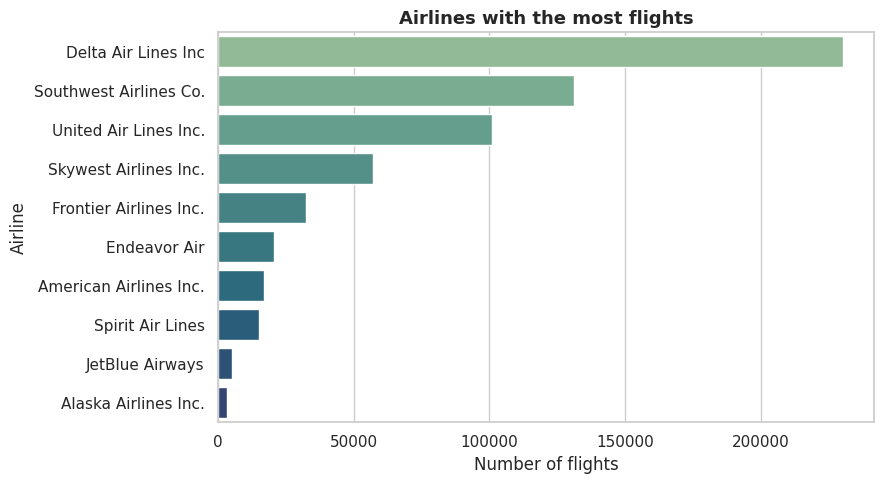

In [22]:
sns.set_theme(style="whitegrid")

airline_counts = df["Airline"].value_counts().head(10).reset_index()
airline_counts.columns = ["Airline", "Count"]

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y="Airline",
    x="Count",
    data=airline_counts,
    palette="crest"
)

plt.title("Airlines with the most flights", fontsize=13, weight="bold")
plt.xlabel("Number of flights")
plt.ylabel("Airline")
plt.tight_layout()
plt.show()


This plot shows that Delta Air Lines operates by far the highest number of flights, followed by Southwest and United. The remaining airlines have significantly fewer flights, indicating a strong concentration among the top carriers.

/tmp/ipykernel_18402/3257869542.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


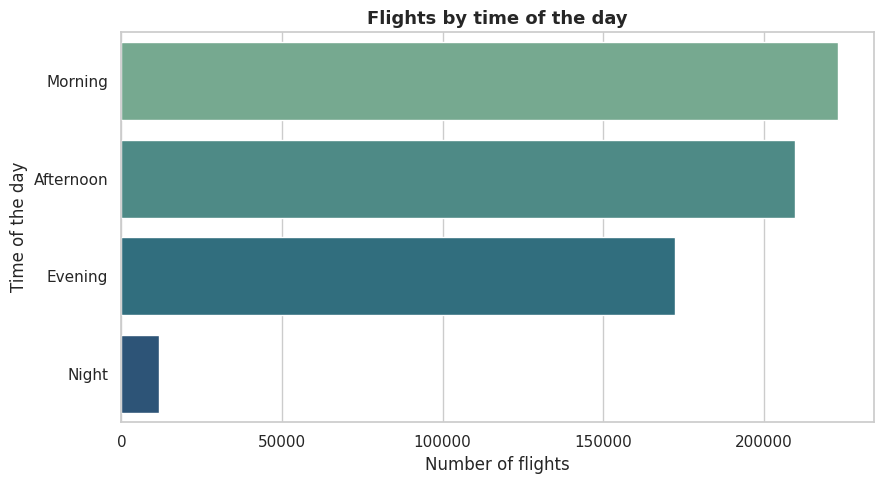

In [23]:
sns.set_theme(style="whitegrid")

airline_counts = df["DepTime_label"].value_counts().head(10).reset_index()
airline_counts.columns = ["DepTime_label", "Count"]

plt.figure(figsize=(9, 5))
ax = sns.barplot(
    y="DepTime_label",
    x="Count",
    data=airline_counts,
    palette="crest"
)

plt.title("Flights by time of the day", fontsize=13, weight="bold")
plt.xlabel("Number of flights")
plt.ylabel("Time of the day")
plt.tight_layout()
plt.show()


This plot shows that most flights occur in the morning and afternoon, followed by the evening period, while night flights are relatively rare.

/tmp/ipykernel_18402/1315110304.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Month', y='Dep_Delay_Tag', data=month_delay, palette='crest')


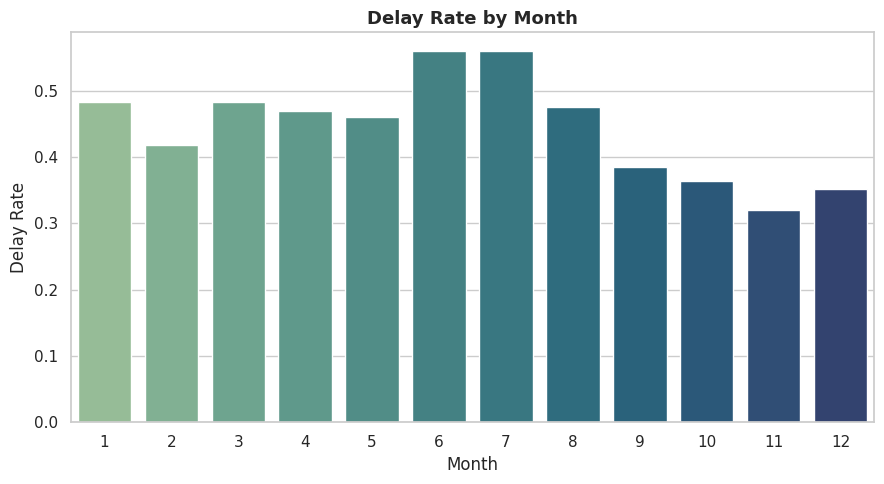

In [24]:
month_delay = df.groupby('Month')['Dep_Delay_Tag'].mean().reset_index()

plt.figure(figsize=(9,5))
sns.barplot(x='Month', y='Dep_Delay_Tag', data=month_delay, palette='crest')
plt.title("Delay Rate by Month", fontsize=13, weight='bold')
plt.xlabel("Month")
plt.ylabel("Delay Rate")
plt.tight_layout()
plt.show()

This plot shows a clear seasonal pattern in flight delays. The probability of delays increases during late spring and summer, peaking around June and July, and then gradually decreases towards the end of the year. 

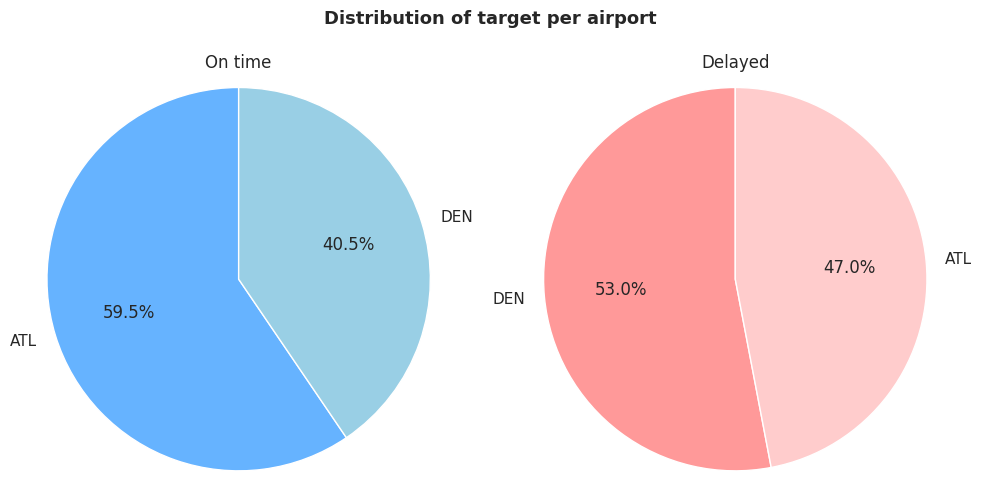

In [25]:
target = "Dep_Delay_Tag"
airport_col = "Dep_Airport"

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

on_time = (
    df_reduced[df_reduced[target] == 0][airport_col]
    .value_counts()
)

axes[0].pie(
    on_time,
    labels=on_time.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff", "#99cfe5"]
)
axes[0].set_title("On time")
axes[0].axis("equal")

delayed = (
    df_reduced[df_reduced[target] == 1][airport_col]
    .value_counts()
)

axes[1].pie(
    delayed,
    labels=delayed.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=["#ff9999", "#ffcccc"]
)
axes[1].set_title("Delayed")
axes[1].axis("equal")

plt.suptitle("Distribution of target per airport", fontsize=13, weight="bold")
plt.tight_layout()
plt.show()


For on-time flights, ATL represents a larger share of the observations compared to DEN. In contrast, for delayed flights, DEN accounts for a higher proportion, indicating a relatively higher incidence of delays at DEN compared to ATL.

/tmp/ipykernel_18402/1416109687.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


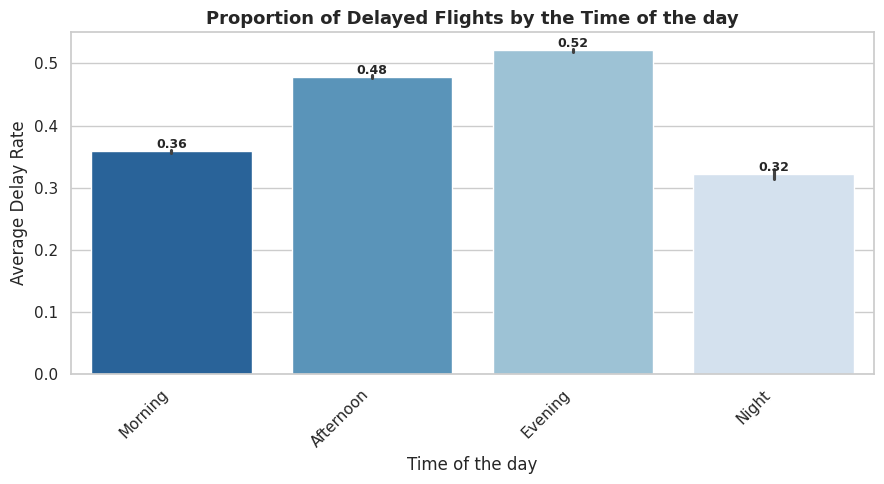

In [26]:
sns.set_theme(style="whitegrid")

categorical_features = ['DepTime_label']

for col in categorical_features:
    plt.figure(figsize=(9,5))
    
    ax = sns.barplot(
        x=col, 
        y="Dep_Delay_Tag", 
        data=df,
        estimator=np.mean,
        order=df[col].value_counts().index,
        palette='Blues_r' 
    )
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9, weight='bold')
    
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Proportion of Delayed Flights by the Time of the day", fontsize=13, weight='bold')
    plt.ylabel("Average Delay Rate")
    plt.xlabel("Time of the day")
    plt.tight_layout()
    plt.show()

The delay rate increases throughout the day, peaking in the evening. Morning and night flights show lower delay proportions, suggesting that delays tend to accumulate as the day progresses.

To better understand external factors that may contribute to flight delays, daily weather data were integrated into the flight dataset.
The weather dataset contains variables such as average temperature (tavg), precipitation (prcp), snowfall (snow), wind direction (wdir), wind speed (wspd), and atmospheric pressure (pres) for each airport and date.

Dep_Delay_Tag    1.000000
wspd             0.114222
prcp             0.068656
snow             0.064416
tavg            -0.008496
pres            -0.079140
Name: Dep_Delay_Tag, dtype: float64


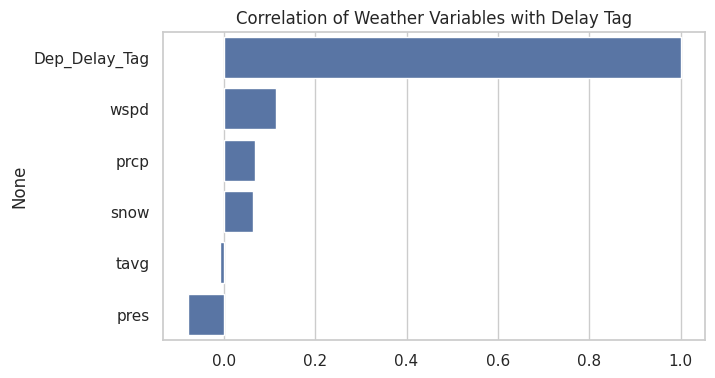

In [27]:
weather_features = ['tavg', 'prcp', 'snow', 'wspd', 'pres']

corr_weather = df[weather_features + ['Dep_Delay_Tag']].corr()['Dep_Delay_Tag'].sort_values(ascending=False)
print(corr_weather)

plt.figure(figsize=(7,4))
sns.barplot(x=corr_weather.values, y=corr_weather.index)
plt.title("Correlation of Weather Variables with Delay Tag")
plt.show()

Weather variables show weak correlations with the delay tag. Wind speed has the strongest positive correlation, while precipitation and snow have smaller effects, suggesting that weather alone has limited linear explanatory power for delays.

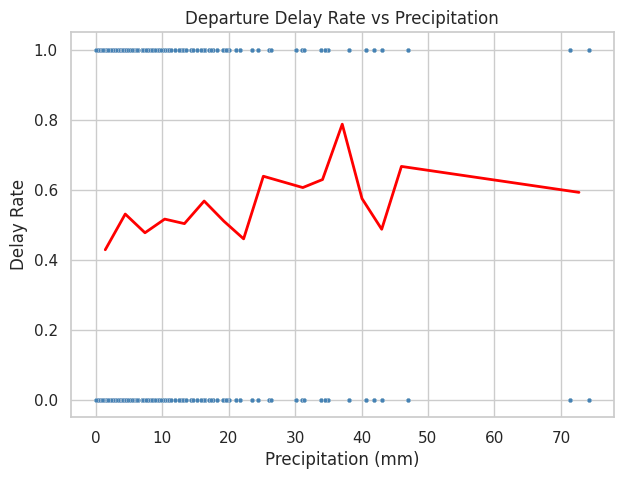

In [28]:
df_temp = df.copy()
df_temp['prcp_bin'] = pd.cut(df_temp['prcp'], bins=25)

delay_by_prcp = df_temp.groupby('prcp_bin', observed=False)['Dep_Delay_Tag'].mean().reset_index()
delay_by_prcp['prcp_mid'] = delay_by_prcp['prcp_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(7,5))
sns.scatterplot(x='prcp', y='Dep_Delay_Tag', data=df, alpha=0.15, s=10, color='steelblue')
sns.lineplot(x='prcp_mid', y='Dep_Delay_Tag', data=delay_by_prcp, color='red', linewidth=2)
plt.title("Departure Delay Rate vs Precipitation")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Delay Rate")
plt.show()


The probability of delay tends to increase with precipitation, however there isn't a trend on the increase of precipitation, so we create a binary class (0 - no rain; 1- rain).

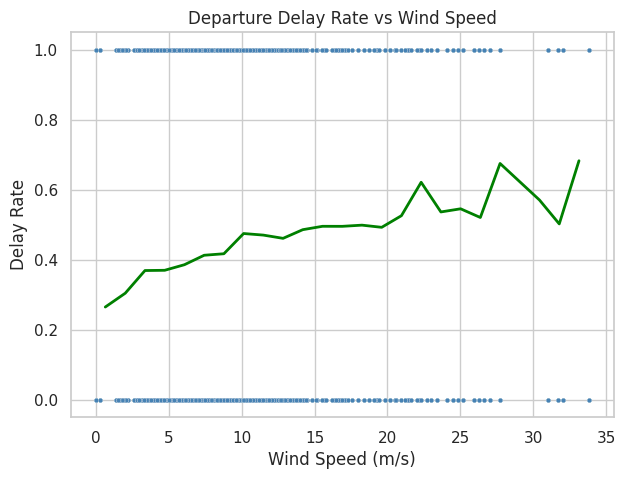

In [29]:
df_temp['wspd_bin'] = pd.cut(df_temp['wspd'], bins=25)
delay_by_wind = df_temp.groupby('wspd_bin', observed=False)['Dep_Delay_Tag'].mean().reset_index()
delay_by_wind['wspd_mid'] = delay_by_wind['wspd_bin'].apply(lambda x: x.mid)

plt.figure(figsize=(7,5))
sns.scatterplot(x='wspd', y='Dep_Delay_Tag', data=df, alpha=0.15, s=10, color='steelblue')
sns.lineplot(x='wspd_mid', y='Dep_Delay_Tag', data=delay_by_wind, color='green', linewidth=2)
plt.title("Departure Delay Rate vs Wind Speed")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Delay Rate")
plt.show()

There is a clearer upward trend between wind speed and delay probability. Higher wind speeds are associated with a higher likelihood of delays, making wind one of the most influential factors in this dataset.

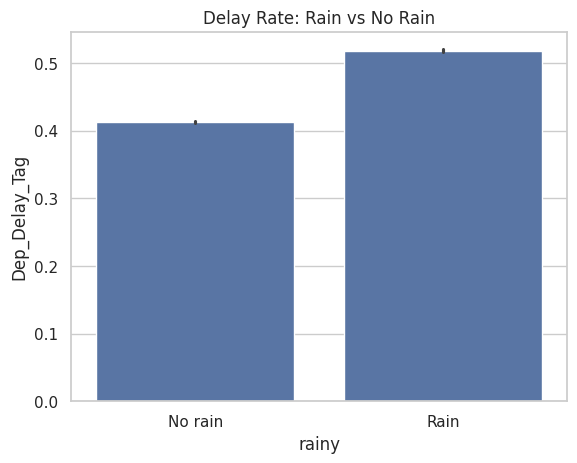

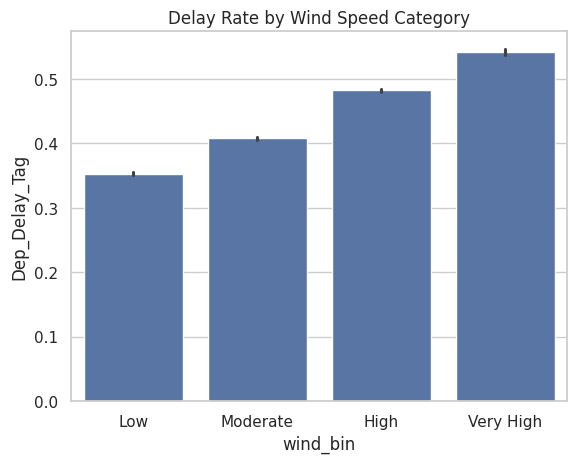

In [30]:
df['rainy'] = (df['prcp'] > 0).astype(int)

sns.barplot(x='rainy', y='Dep_Delay_Tag', data=df)
plt.xticks([0,1], ['No rain', 'Rain'])
plt.title("Delay Rate: Rain vs No Rain")
plt.show()

df['wind_bin'] = pd.cut(df['wspd'], bins=[0,5,10,20,40], labels=['Low','Moderate','High','Very High'])
sns.barplot(x='wind_bin', y='Dep_Delay_Tag', data=df)
plt.title("Delay Rate by Wind Speed Category")
plt.show()

Flights operating under rainy conditions show a higher probability of delay compared to flights with no rain, indicating that rainfall has a noticeable impact on departure delays.

As seen before, the delay rate increases consistently with wind speed category. Flights under high and very high wind conditions exhibit the highest delay probabilities, reinforcing wind speed as a key weather-related factor.

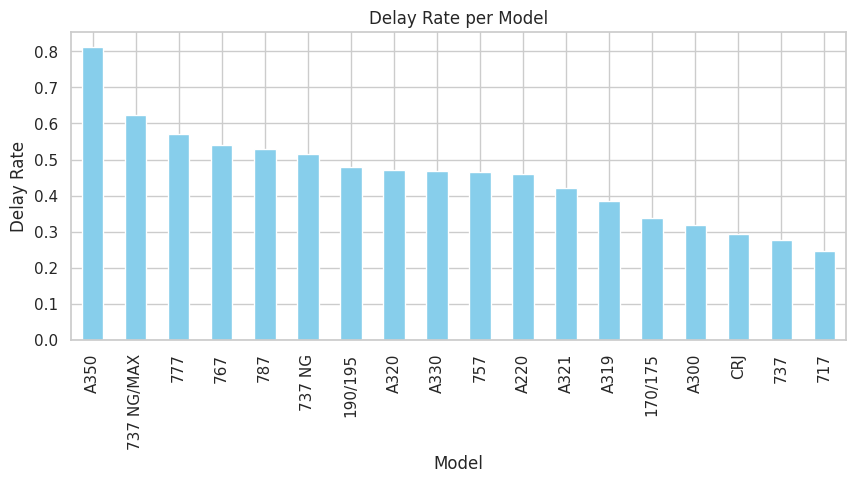

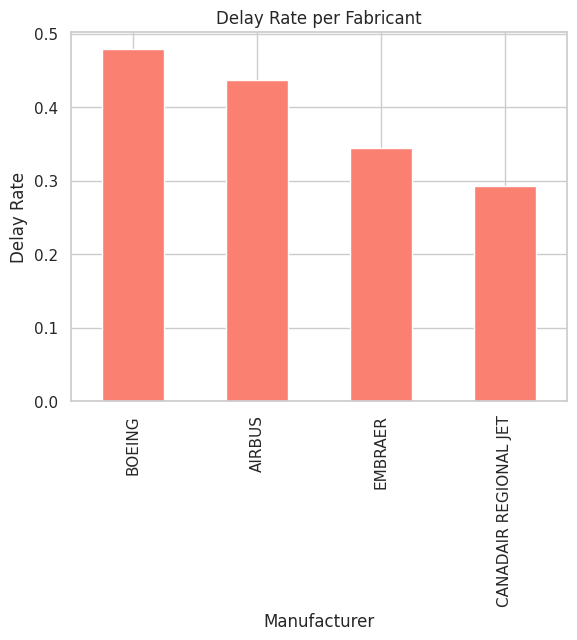

In [31]:
model_delay = df.groupby("Model")["Dep_Delay_Tag"].mean().sort_values(ascending=False)

man_delay = df.groupby("Manufacturer")["Dep_Delay_Tag"].mean().sort_values(ascending=False)

model_delay.plot(kind="bar", figsize=(10,4), color="skyblue")
plt.title("Delay Rate per Model")
plt.ylabel("Delay Rate")
plt.show()

man_delay.plot(kind="bar", color="salmon")
plt.title("Delay Rate per Fabricant")
plt.ylabel("Delay Rate")
plt.show()

The delay rate varies noticeably across aircraft models. Some models, such as the A350 and Boeing 737 NG/MAX, show higher delay rates, while others present lower values. This suggests that operational patterns associated with specific aircraft models may influence delay likelihood.

On the Fabricant side, Boeing aircraft exhibits the highest average delay rate, followed by Airbus. Embraer and Canadair show lower delay rates, possibly reflecting differences in route types or operational environments.

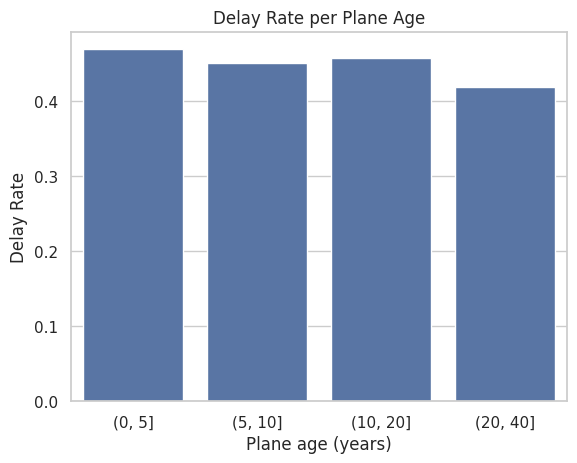

In [32]:
sns.barplot(x=pd.cut(df["Aicraft_age"], bins=[0,5,10,20,40]),
            y="Dep_Delay_Tag", data=df, errorbar=None)
plt.title("Delay Rate per Plane Age")
plt.xlabel("Plane age (years)")
plt.ylabel("Delay Rate")
plt.show()

We can see that there isn't a trend on the age of the plane and the Delay Rate

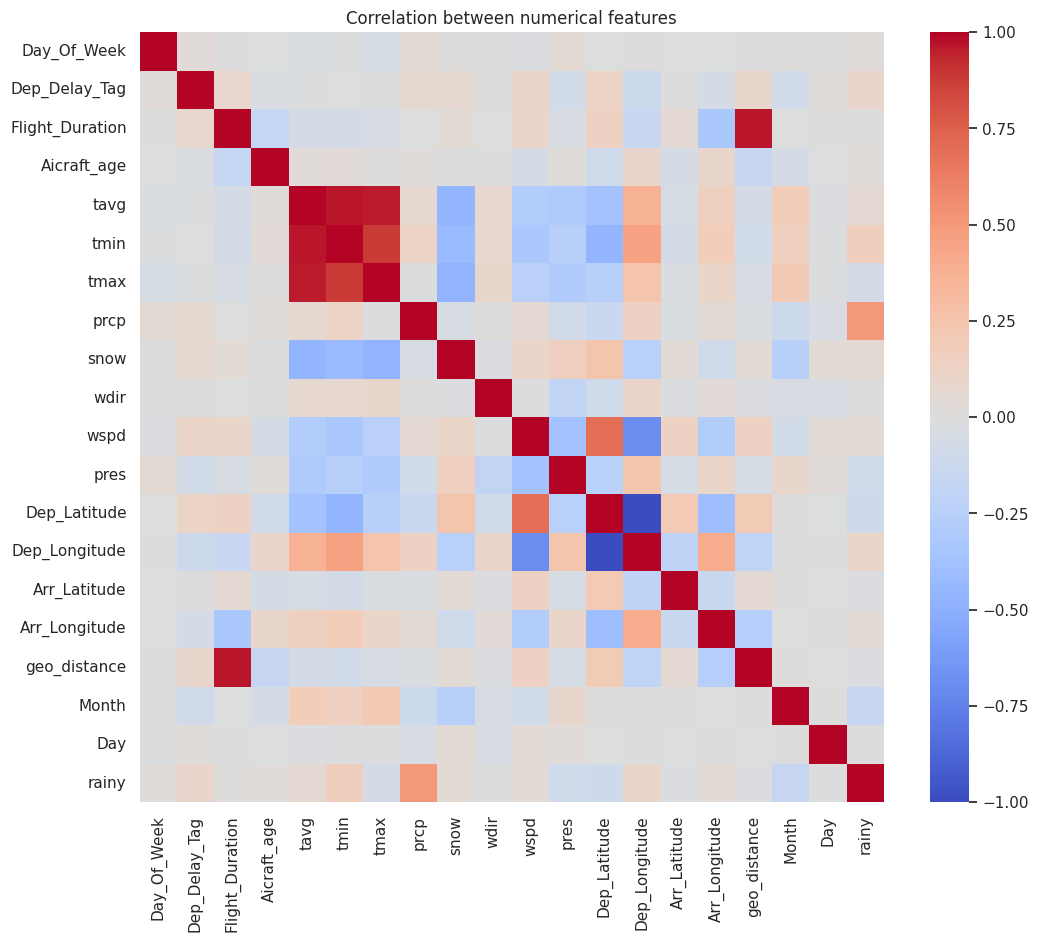

In [33]:
num_cols = df.select_dtypes(include=["number"])

corr = num_cols.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation between numerical features")
plt.show()

The correlation matrix reveals mostly weak linear relationships with the delay tag, indicating that delays are influenced by multiple interacting factors rather than a single dominant variable. Strong correlations are observed among temperature-related variables (tavg, tmin, tmax), as expected, and between geographic coordinates and flight distance. Weather variables such as wind speed and precipitation show mild positive correlations with delays, supporting their relevance while also highlighting the need for non-linear models to capture more complex patterns.

After a detailed analysis of the features and their correlations, we decided to remove a subset of variables that were either redundant, highly correlated, or not directly relevant for the modeling task.


| Category | Removed Features |
|--------|------------------|
| **Weather (redundancy)** | `tmin`, `tmax`, `prcp`, `wind_bin` |
| **Aircraft metadata** | `Tail_Number`, `Manufacturer` |
| **Departure location details** | `Dep_CityName`, `Dep_Airport`, `Dep_City`, `Dep_State`, `Dep_Country` |
| **Arrival location details** | `Arr_CityName`, `Arr_Airport`, `Arr_City`, `Arr_State`, `Arr_Country` |
| **Geographic coordinates (redundancy)** | `Dep_Latitude`, `Dep_Longitude`, `Arr_Latitude`, `Arr_Longitude` |
| **Distance-related** | `Distance_type`, `Flight_Duration` |


In [34]:
df=df.drop(columns=["tmin", 
                    "tmax", 
                    "prcp",
                    "wind_bin", 
                    "Tail_Number",
                    "Manufacturer", 
                    "Dep_CityName", 
                    "Arr_CityName",
                    "Dep_Airport", 
                    "Dep_City", 
                    "Dep_State", 
                    "Dep_Country",
                    "Arr_Airport", 
                    "Arr_City", 
                    "Arr_State", 
                    "Arr_Country",
                    "Dep_Latitude", 
                    "Dep_Longitude", 
                    "Arr_Latitude", 
                    "Arr_Longitude", 
                    "Distance_type",
                    "Flight_Duration"])

In [35]:
df

Day_Of_Week          Airline DepTime_label  Dep_Delay_Tag    Model  \
0                 1     Endeavor Air     Afternoon              0      CRJ   
1                 2     Endeavor Air     Afternoon              0      CRJ   
2                 3     Endeavor Air     Afternoon              0      CRJ   
3                 4     Endeavor Air     Afternoon              1      CRJ   
4                 5     Endeavor Air     Afternoon              0      CRJ   
...             ...              ...           ...            ...      ...   
617130            7  JetBlue Airways       Morning              0     A320   
617131            7  JetBlue Airways     Afternoon              0  190/195   
617132            7  JetBlue Airways       Morning              0     A220   
617133            7  JetBlue Airways     Afternoon              1  190/195   
617134            7  JetBlue Airways     Afternoon              1     A320   

        Aicraft_age  tavg  snow   wdir  wspd    pres  \
0                16   8.0   0.0  320.0   9.3  1021.1   
1                16   7.3   0.0  328.0   2.7  1019.0   
2                16  11.0   0.0  340.0   3.2  1017.5   
3                21  15.5   0.0  224.0  11.7  1012.4   
4                10   5.7   0.0  318.0  19.8  1015.0   
...             ...   ...   ...    ...   ...     ...   
617130           22   4.8   0.0  309.0   5.0  1020.7   
617131           18   4.8   0.0  309.0   5.0  1020.7   
617132            3   4.8   0.0  309.0   5.0  1020.7   
617133           14   4.8   0.0  309.0   5.0  1020.7   
617134           21   4.8   0.0  309.0   5.0  1020.7   

                                        Dep_Airport_Name  \
0       Hartsfield-Jackson Atlanta International Airport   
1       Hartsfield-Jackson Atlanta International Airport   
2       Hartsfield-Jackson Atlanta International Airport   
3       Hartsfield-Jackson Atlanta International Airport   
4       Hartsfield-Jackson Atlanta International Airport   
...                                                  ...   
617130  Hartsfield-Jackson Atlanta International Airport   
617131  Hartsfield-Jackson Atlanta International Airport   
617132  Hartsfield-Jackson Atlanta International Airport   
617133  Hartsfield-Jackson Atlanta International Airport   
617134  Hartsfield-Jackson Atlanta International Airport   

                                         Arr_Airport_Name  geo_distance  \
0                           Fayetteville Regional Airport    531.034581   
1                           Fayetteville Regional Airport    531.034581   
2                           Fayetteville Regional Airport    531.034581   
3                           Fayetteville Regional Airport    531.034581   
4                           Fayetteville Regional Airport    531.034581   
...                                                   ...           ...   
617130    Fort Lauderdale-Hollywood International Airport    936.761999   
617131  John F. Kennedy International Airport (New Yor...   1221.727276   
617132   Gen. Edward Lawrence Logan International Airport   1521.194231   
617133  John F. Kennedy International Airport (New Yor...   1221.727276   
617134    Fort Lauderdale-Hollywood International Airport    936.761999   

        Month  Day  rainy  
0           1    9      0  
1           1   10      0  
2           1   11      0  
3           1   12      1  
4           1   13      1  
...       ...  ...    ...  
617130     12   31      0  
617131     12   31      0  
617132     12   31      0  
617133     12   31      0  
617134     12   31      0  

[617135 rows x 17 columns]

In [36]:
df.to_csv("small_dataset.csv", index=False)

## Encoding

After removing the selected features, we proceed with the encoding of the remaining non-numerical variables using **Label Encoding**.  
This choice was made because applying **One-Hot Encoding** would significantly increase the dimensionality of the dataset due to the high number of unique categories.

Since our models of choice are **Decision Trees** and **Random Forests**, which can naturally handle ordinal encodings without assuming linear relationships, Label Encoding is a suitable and efficient option in this context.


In [37]:
df=pd.read_csv("small_dataset.csv")

In [38]:
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

### Correlation Analysis

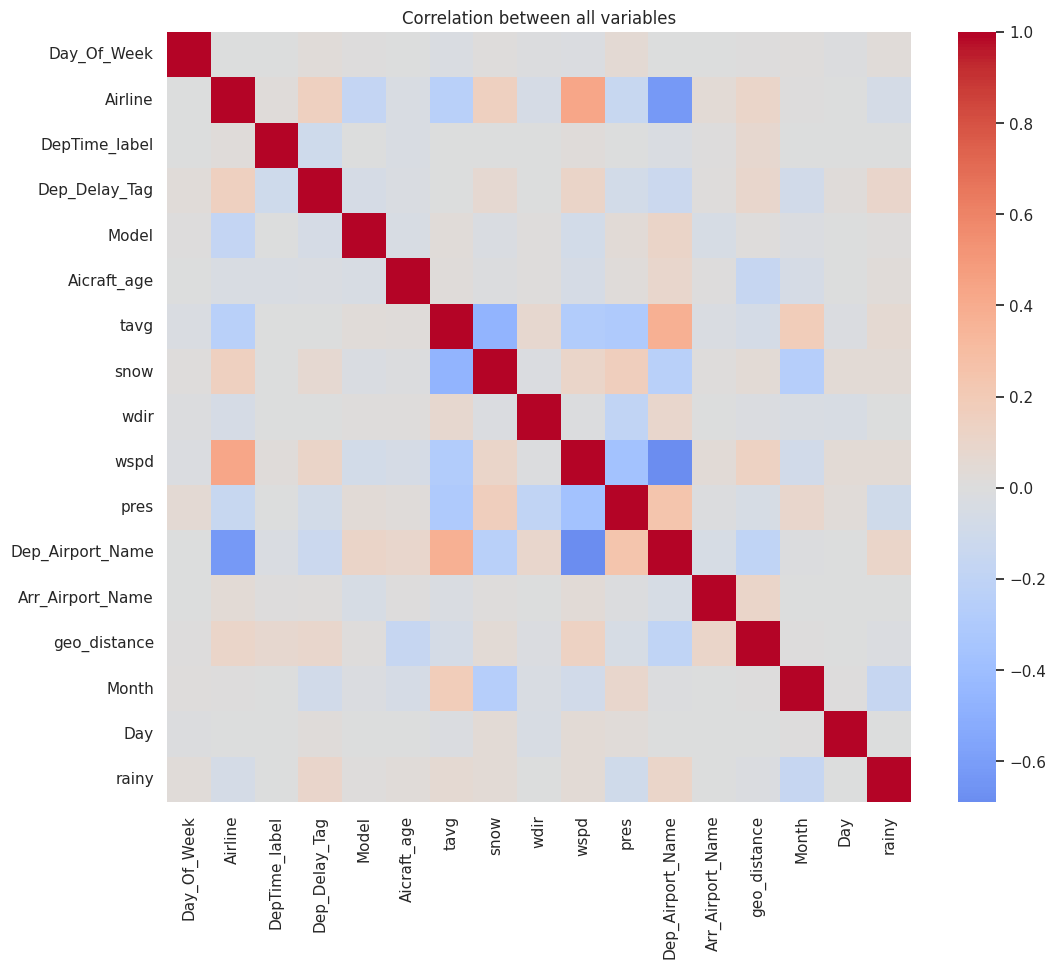

In [39]:
corr = df_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation between all variables")
plt.show()

In [40]:
corr_target = df_encoded.corr()["Dep_Delay_Tag"].sort_values(ascending=False)

/tmp/ipykernel_18402/1907455811.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")


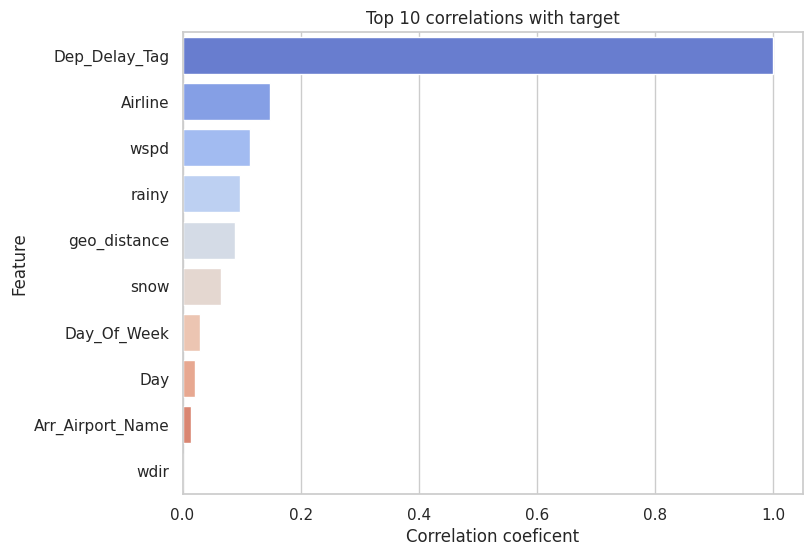

In [41]:
top_corr = corr_target.head(10)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_corr.values, y=top_corr.index, palette="coolwarm")
plt.title("Top 10 correlations with target")
plt.xlabel("Correlation coeficent")
plt.ylabel("Feature")
plt.show()

This plot highlights the top features with the highest correlation coefficients relative to the delay tag. Excluding the target itself, **Airline** shows the strongest correlation, suggesting that carrier-specific operational factors may influence delay likelihood.

Weather-related variables such as **wind speed (wspd)**, **rain**, and **snow** also appear among the top correlated features, reinforcing their role in increasing the probability of delays. In contrast, temporal variables like **Day_of_Week** and geographic features exhibit very weak correlations, indicating a limited linear impact on delays when considered individually.

Overall, the low magnitude of these correlations supports the use of non-linear models, as important effects are likely captured through interactions rather than direct linear relationships.


## Dimensionality Reduction: PCA and t-SNE

Before applying any models or explainability techniques, we first explore **pre-XAI methods** to better understand the structure of the data. Dimensionality reduction techniques allow us to analyze high-dimensional feature spaces by projecting the data into lower-dimensional representations while preserving relevant information.

In this context, we apply **Principal Component Analysis (PCA)** and **t-Distributed Stochastic Neighbor Embedding (t-SNE)**. PCA helps identify the main directions of variance in the data, while t-SNE focuses on capturing local similarities and potential clustering patterns. These techniques provide valuable insights into the separability and intrinsic structure of the dataset prior to model explainability.

**Note:** We use only numerical variables, as including encoded categorical features could introduce artificial relationships that do not exist in the original data.


### PCA

In [42]:
numerical_df = df.select_dtypes(include=['int64', 'float64']).copy()

In [43]:
y= numerical_df["Dep_Delay_Tag"]                   

In [44]:
numerical_df = numerical_df.drop(columns=['Dep_Delay_Tag','Day_Of_Week'], errors='ignore')

In [45]:
print("Numerical variables used for PCA:")
print(numerical_df.columns.tolist())

Numerical variables used for PCA:
['Aicraft_age', 'tavg', 'snow', 'wdir', 'wspd', 'pres', 'geo_distance', 'Month', 'Day', 'rainy']


In [46]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_df)


In [47]:
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

explained_variance = pca.explained_variance_ratio_

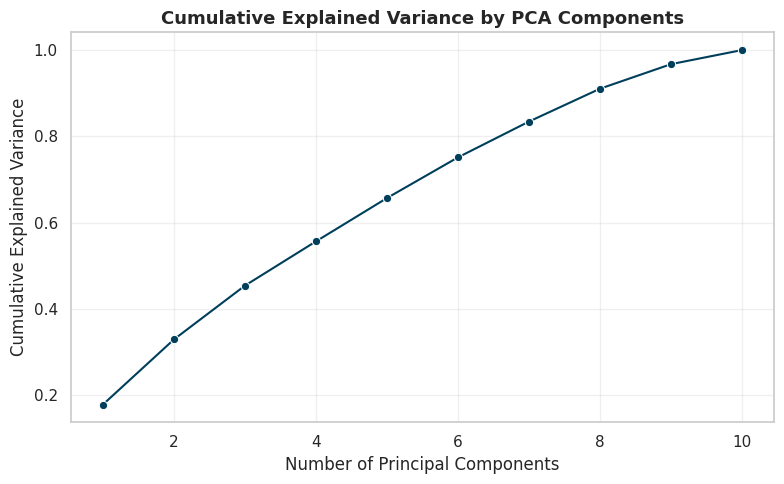

In [48]:
plt.figure(figsize=(8,5))
sns.lineplot(x=range(1, len(explained_variance)+1), y=explained_variance.cumsum(), marker='o', color='#003f5c')
plt.title("Cumulative Explained Variance by PCA Components", fontsize=13, weight='bold')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### PCA – Cumulative Explained Variance

This plot shows the cumulative explained variance as the number of principal components increases. We observe that variance is gradually accumulated, with around 75% of the total variance explained by the first six components and over 90% captured with approximately eight components.


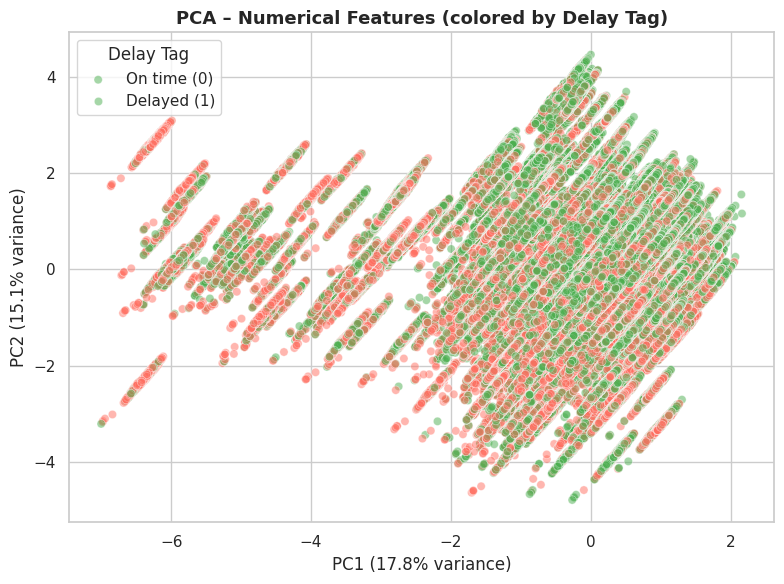

In [49]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Dep_Delay_Tag'] = df['Dep_Delay_Tag']

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PC1', y='PC2', data=df_pca,
    hue='Dep_Delay_Tag', palette=['#4CAF50', '#FF6F61'], alpha=0.5
)
plt.title("PCA – Numerical Features (colored by Delay Tag)", fontsize=13, weight='bold')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.legend(title='Delay Tag', labels=['On time (0)', 'Delayed (1)'])
plt.tight_layout()
plt.show()


In [50]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=numerical_df.columns
)
print(loadings.sort_values(by='PC1', ascending=False).head(10))


                   PC1       PC2
tavg          0.624778 -0.102904
Month         0.337483  0.223197
wdir          0.121978 -0.263891
Aicraft_age   0.046980  0.101295
rainy        -0.039551 -0.238055
Day          -0.067581  0.025932
geo_distance -0.130217 -0.203972
pres         -0.202720  0.682890
wspd         -0.280781 -0.539950
snow         -0.579354  0.053505


### PCA – Projection on the First Two Components

The scatter plot of the first two principal components (PC1 and PC2) shows a substantial overlap between delayed and on-time flights. Although these two components explain a non-negligible portion of the variance, they do not provide a clear linear separation between the two classes. This suggests that the distinction between delayed and non-delayed flights is not driven by simple linear combinations of numerical features, reinforcing the need for non-linear models and more advanced analysis techniques.

### t-SNE

Due to the high computational cost and scalability limitations of t-SNE, it is not feasible to apply it to the full dataset. For this reason, we use a subset of **50,000 randomly sampled instances**, which provides a good trade-off between computational feasibility and representativeness of the data.

Random sampling preserves the overall data distribution while avoiding biases toward specific patterns. The plot below confirms that the random subsample used for t-SNE preserves the original class distribution, ensuring that the visualization remains representative of the full dataset.



In [51]:
rng = np.random.RandomState(42)
n = min(50000, len(numerical_df))
idx = rng.choice(len(numerical_df), size=n, replace=False)
X_sample = numerical_df.iloc[idx].copy()
y_sample = y.iloc[idx].copy()

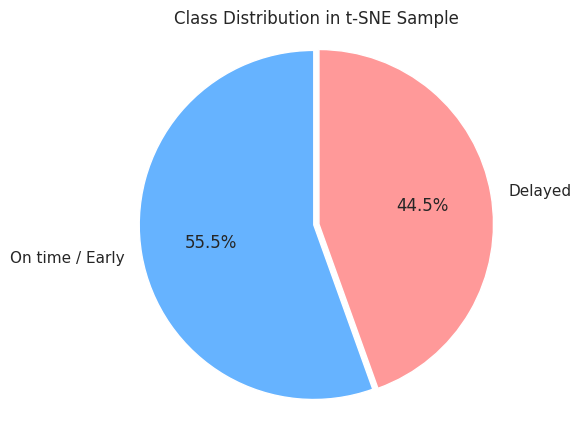

In [52]:
contagem = y_sample.value_counts().sort_index()

plt.figure(figsize=(5, 5))
plt.pie(
    contagem,
    labels=["On time / Early", "Delayed"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["#66b3ff", "#ff9999"],
    explode=(0.03, 0)
)
plt.title("Class Distribution in t-SNE Sample")
plt.axis("equal")
plt.show()

In [53]:
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X_sample)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 0.031s...
[t-SNE] Computed neighbors for 50000 samples in 7.020s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for sam

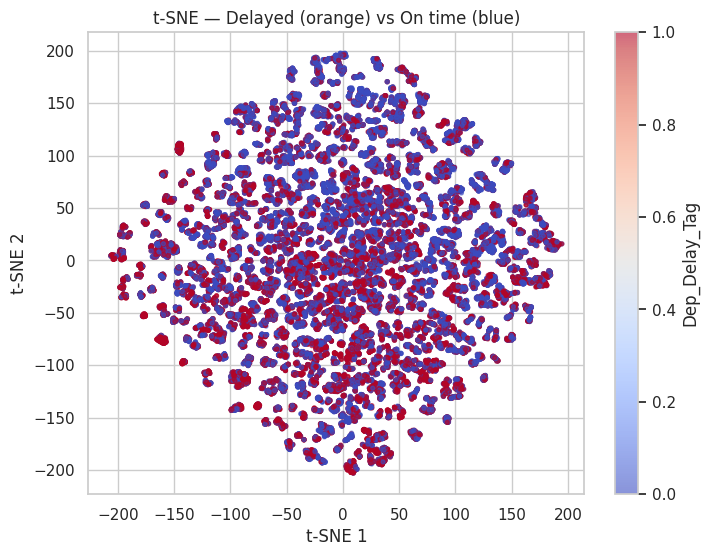

In [54]:
tsne = TSNE(
    n_components=2,
    perplexity=30,       
    learning_rate="auto",
    max_iter=2000,
    init="pca",         
    metric="euclidean",
    random_state=42,
    verbose=1
)

Z = tsne.fit_transform(X_scaled)  

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=y_sample, cmap="coolwarm", s=8, alpha=0.6)
plt.title("t-SNE — Delayed (orange) vs On time (blue)")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.colorbar(label="Dep_Delay_Tag")
plt.show()

### t-SNE Visualization

The t-SNE projection shows a strong overlap between delayed and on-time flights, with no clearly separable clusters associated with each class. This indicates that, when considering only numerical features, the two classes are highly intermixed in the feature space.

Although some local groupings can be observed, they contain a mixture of both delayed and non-delayed instances. This reinforces the complexity of the problem and the need for non-linear models to capture subtle interactions between features.


# Task 2: In-Modeling Explanations

[Back to the top](#Table-of-Contents)

After exploring and understanding the dataset in the pre-modelling phase, the next step focuses on developing a predictive model that are inherently interpretable. The goal of this stage is to build a transparent, glass-box model that not only achieve reliable performance but also allow a direct understanding of how different variables influence flight delays. By using the decision tree, it becomes possible to examine feature importance, and decision rules that describe the underlying relationships between flight characteristics and the likelihood of a delay. 

### Glass-Box Model (Decision Tree) — Results and Interpretability

As stated previously, we selected the **Decision Tree** algorithm as our glass-box model due to its inherent interpretability. We adopted a standard **80/20 train–test split**, as our primary focus is on **explainability and interpretability** rather than achieving optimal predictive performance.


In [55]:
X = df_encoded.drop(columns=["Dep_Delay_Tag"])
y = df_encoded["Dep_Delay_Tag"].astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
tree = DecisionTreeClassifier(
    criterion="gini",  
    max_depth=5,        
    random_state=42
)

tree.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.6492015523345783
              precision    recall  f1-score   support

           0       0.65      0.82      0.72     68613
           1       0.66      0.44      0.53     54814

    accuracy                           0.65    123427
   macro avg       0.65      0.63      0.62    123427
weighted avg       0.65      0.65      0.63    123427

Matriz de confusão:
 [[56070 12543]
 [30755 24059]]


In [58]:
importances = tree.feature_importances_
feat_names = X.columns

indices = np.argsort(importances)[::-1]
for i in range(len(feat_names)):
    print(f"{i+1}. {feat_names[indices[i]]}: {importances[indices[i]]:.3f}")


1. Airline: 0.441
2. DepTime_label: 0.236
3. Month: 0.177
4. Model: 0.041
5. rainy: 0.040
6. geo_distance: 0.038
7. tavg: 0.016
8. Dep_Airport_Name: 0.012
9. wspd: 0.000
10. pres: 0.000
11. Arr_Airport_Name: 0.000
12. Day: 0.000
13. Aicraft_age: 0.000
14. snow: 0.000
15. wdir: 0.000
16. Day_Of_Week: 0.000


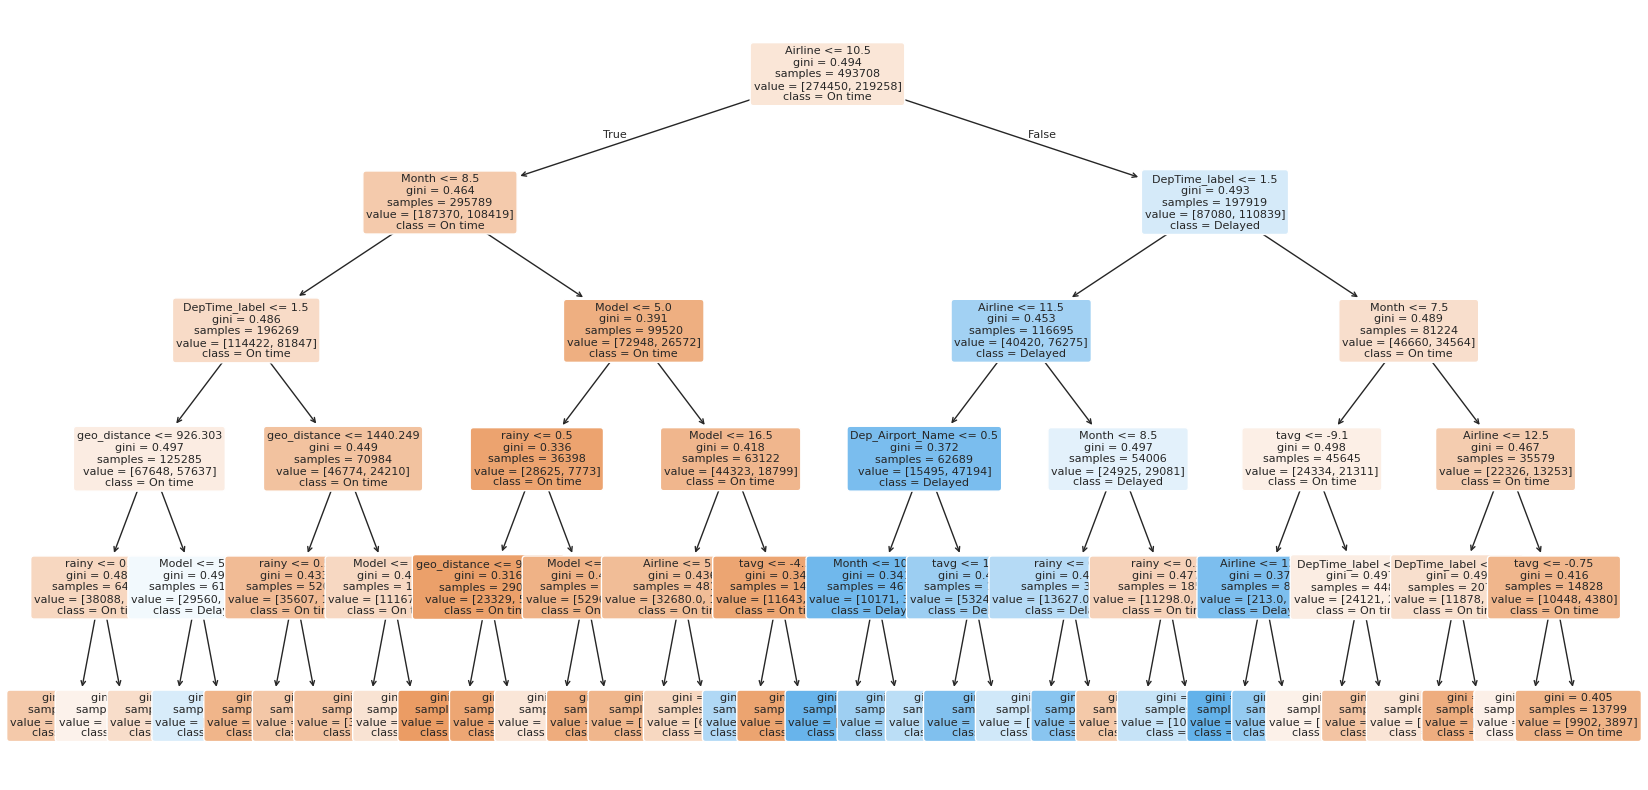

In [59]:
plt.figure(figsize=(20,10))
sktree.plot_tree(tree, 
                 feature_names=feat_names, 
                 class_names=["On time", "Delayed"],
                 filled=True, 
                 rounded=True, 
                 fontsize=8)
plt.show()


### Predictive Performance
The Decision Tree achieves an accuracy of **0.65**. However, the performance is clearly asymmetric across classes:
- For **on-time flights (class 0)** the model has a **high recall (0.82)**, meaning it correctly identifies most flights that are not delayed.
- For **delayed flights (class 1)** the recall is **much lower (0.44)**, meaning many delayed flights are misclassified as on-time.

This is also visible in the confusion matrix, where the number of **false negatives** (delayed flights predicted as on-time) is relatively high. This tell us that the model is better at explaining why a flight is likely on-time than reliably detecting delays.

### Feature Importance (Global Explanation)
The feature importances show that the model relies heavily on a small number of variables such as, **Airline (0.44)**, **DepTime_label (0.24)** and **Month (0.18)**  
Then, with much smaller contributions we have **Model**, **rainy**, **geo_distance**, and **tavg**.

### Decision Rules (Human-Readable Explanation)
A key advantage of a glass-box model is that we can directly inspect the learned rules. In the plotted tree, the top splits are mainly based on the same fetures that we refer previously.

This indicates that the model explains delays mostly through *structured, interpretable rules* such as:
- certain airlines being associated with higher delay likelihood,
- specific time-of-day categories being more delay-prone (the model separates Morning and Afternoon from Evening and Night),
- and seasonal effects amplifying or reducing delay probability.

### Important Note on Interpretability with Label Encoding
Because **Airline**, **DepTime_label**, and airport names are label-encoded, the tree thresholds (e.g., `Airline <= 10.5`) do **not** represent meaningful numeric ordering.  
Therefore, interpretability should focus on **which variables** are important and **how early** they appear in the tree, rather than the specific numeric thresholds themselves.


# Task 3: Post-Modelling Explanations 

### Black-Box Model: Random Forest

[Back to the top](#Table-of-Contents)

To complement the glass-box approach, we now move to a **black-box model** using a **Random Forest** classifier. Random Forests are capable of capturing complex, non-linear relationships by combining multiple decision trees, often leading to improved predictive performance. 

While individual decisions are no longer directly interpretable, this model provides a strong baseline for comparison and motivates the use of post-hoc explainability techniques to understand its behavior.

In [60]:
rf = RandomForestClassifier(
    n_estimators=200,    
    max_depth=30,       
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)


RandomForestClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [61]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.698121156635096

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.81      0.75     68613
           1       0.70      0.56      0.62     54814

    accuracy                           0.70    123427
   macro avg       0.70      0.68      0.69    123427
weighted avg       0.70      0.70      0.69    123427


Confusion Matrix:
 [[55409 13204]
 [24056 30758]]


/tmp/ipykernel_18402/1087634244.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


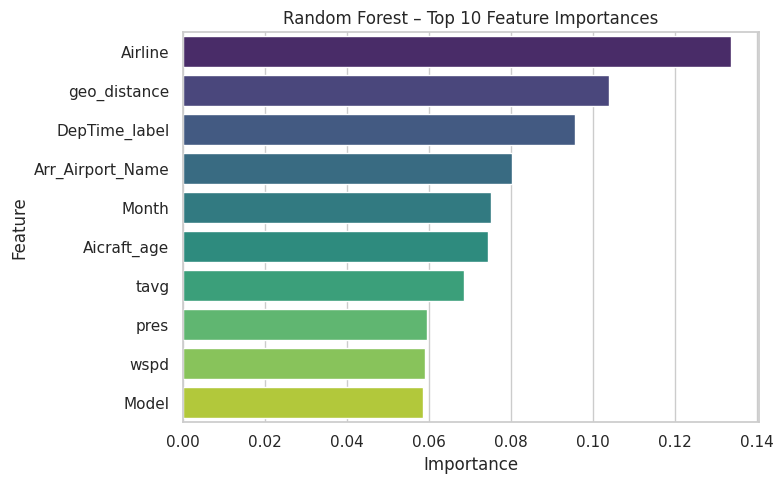

In [62]:
importances = rf.feature_importances_
features = X_train.columns

fi_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(
    data=fi_df.head(10),
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Random Forest – Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Black-Box Model Performance (Random Forest)

The Random Forest model achieves an accuracy of approximately **0.70**, improving upon the performance of the glass-box model. The confusion matrix shows a reduction in false negatives compared to the Decision Tree, indicating a better ability to correctly identify delayed flights.

Nevertheless, a noticeable number of delayed flights are still misclassified as on-time, highlighting the intrinsic difficulty of the problem. Given the increased model complexity and reduced transparency, these results motivate the use of **XAI techniques** to better understand the decision-making process of the black-box model, which is the main focus of the next section.


## Task 3.1 - Simplification-Based Technique
[Back to the top](#Table-of-Contents)

The aim of this subtask is to approximate the behaviour of the trained black-box model (e.g., Random Forest) using a simpler, inherently interpretable model such as a Decision Tree and Logistic Regression.
This surrogate model is trained on the predictions of the black box rather than on the true labels, allowing it to mimic the complex model’s decision boundaries in a more transparent form.

Surrogate fidelity to black-box: 0.792


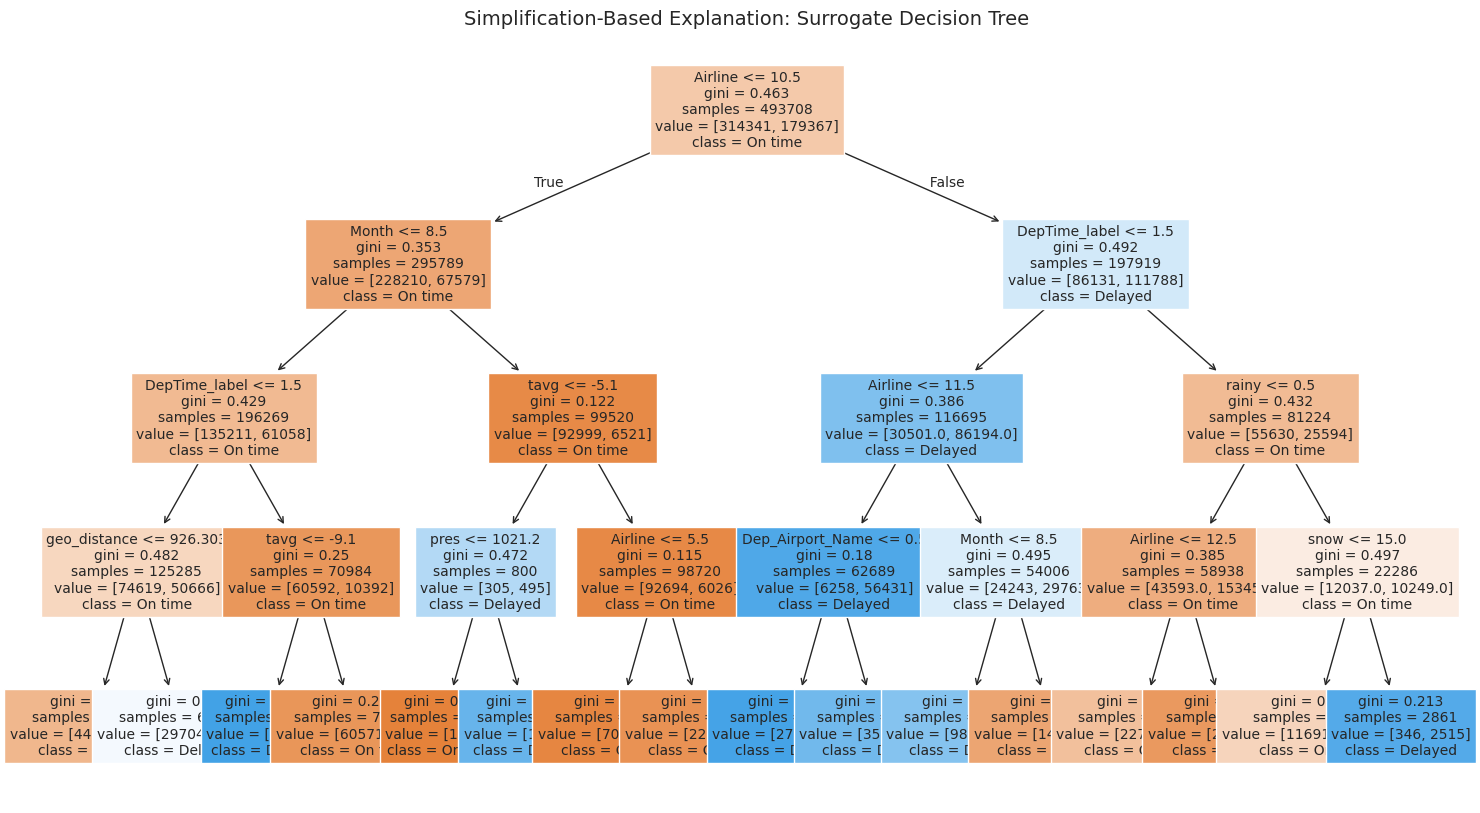

In [63]:
y_pred_train = rf.predict(X_train)

surrogate = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate.fit(X_train, y_pred_train)

y_pred_surrogate = surrogate.predict(X_test)
y_pred_rf = rf.predict(X_test)
fidelity = accuracy_score(y_pred_rf, y_pred_surrogate)
print(f"Surrogate fidelity to black-box: {fidelity:.3f}")

plt.figure(figsize=(18, 10))
plot_tree(
    surrogate,
    feature_names=X_train.columns,
    class_names=["On time", "Delayed"],
    filled=True,
    fontsize=10
)
plt.title("Simplification-Based Explanation: Surrogate Decision Tree", fontsize=14)
plt.show()

Depth 2: fidelity = 0.7604
Depth 3: fidelity = 0.7607
Depth 4: fidelity = 0.7917
Depth 5: fidelity = 0.8078
Depth 6: fidelity = 0.8105
Depth 7: fidelity = 0.8310
Depth 8: fidelity = 0.8431


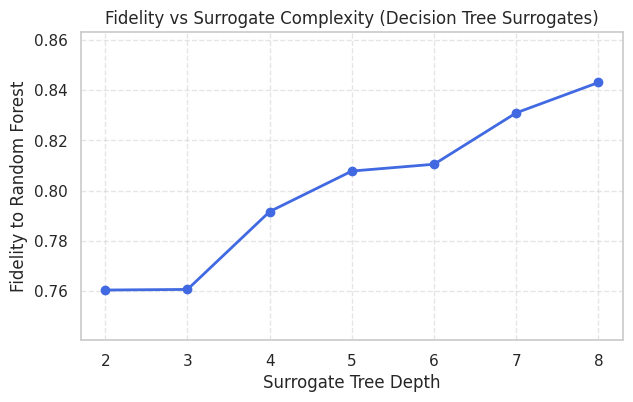

In [64]:
depths = range(2, 9)
fidelities = []

y_pred_train = rf.predict(X_train)

for d in depths:
    surrogate_d = DecisionTreeClassifier(max_depth=d, random_state=42)
    surrogate_d.fit(X_train, y_pred_train)
    
    fidelity_d = accuracy_score(rf.predict(X_test), surrogate_d.predict(X_test))
    fidelities.append(fidelity_d)
    
    print(f"Depth {d}: fidelity = {fidelity_d:.4f}")

plt.figure(figsize=(7,4))
plt.plot(depths, fidelities, marker='o', linewidth=2, color='royalblue')
plt.xticks(depths)
plt.ylim(min(fidelities) - 0.02, max(fidelities) + 0.02)
plt.xlabel("Surrogate Tree Depth")
plt.ylabel("Fidelity to Random Forest")
plt.title("Fidelity vs Surrogate Complexity (Decision Tree Surrogates)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [65]:
print("Random Forest accuracy on y_test:",
      accuracy_score(y_test, y_pred_rf))

print("Surrogate Tree accuracy on y_test:",
      accuracy_score(y_test, y_pred_surrogate))

print("\nSurrogate vs RF (fidelity):", fidelity)

print("\nSurrogate confusion matrix vs RF predictions:")
print(confusion_matrix(y_pred_rf, y_pred_surrogate))

Random Forest accuracy on y_test: 0.698121156635096
Surrogate Tree accuracy on y_test: 0.6449399240036621

Surrogate vs RF (fidelity): 0.7916663290852083

Surrogate confusion matrix vs RF predictions:
[[68075 11390]
 [14324 29638]]


In [66]:
log_surrogate = LogisticRegression(max_iter=500)
log_surrogate.fit(X_train, y_pred_train)

fidelity_log = accuracy_score(rf.predict(X_test), log_surrogate.predict(X_test))
print("Logistic surrogate fidelity:", fidelity_log)

/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic surrogate fidelity: 0.7304479570920464


### Surrogate Decision Tree 

The surrogate decision tree provides a simplified, interpretable approximation of the Random Forest’s decision process. By training the tree to predict the black-box model’s outputs, we can extract human-readable decision rules that summarize the most influential patterns learned by the Random Forest.

### Fidelity vs Surrogate Complexity

The plot bellow illustrates the trade-off between **interpretability** and **fidelity**. As the depth of the surrogate tree increases, its fidelity to the Random Forest also improves, meaning the surrogate better approximates the black-box predictions. However, deeper trees become harder to interpret. We therefore select a moderate depth that balances **high fidelity** with **clear interpretability**.

### Surrogate vs Random Forest

While Random Forest achieves an accuracy of **0.70**, the surrogate decision tree reaches **0.64**. This drop is expected, since the surrogate is intentionally simpler and prioritizes interpretability over predictive performance.

More importantly, the surrogate’s **fidelity to the Random Forest is ~0.79** meaning that the surrogate captures a substantial portion of the Random Forest’s behavior, making it useful for global, rule-based explanations.

Overall, these results confirm the typical trade-off: the surrogate is less accurate than the black-box model, but still provides a reasonably faithful and interpretable approximation of its decision logic.



## Task 3.2 - Feature-Based Techniques

[Back to the top](#Table-of-Contents)

This subtask focuses on quantifying and visualising the contribution of each feature to the model’s predictions. Two complementary model-agnostic methods are applied:

- **SHAP (SHapley Additive exPlanations)**, which attributes each feature a fair share of influence based on cooperative game theory;
- **LIME (Local Interpretable Model-agnostic Explanations)**, which approximates the model locally around a chosen instance using a simple linear model.


### SHAP Global Explanation

For the **global SHAP analysis**, we use a random subset of **500 instances**. This choice is motivated by the high computational cost of SHAP when applied to ensemble models such as Random Forests.

In [67]:
X_test_sample = X_test.sample(500, random_state=42)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_sample)

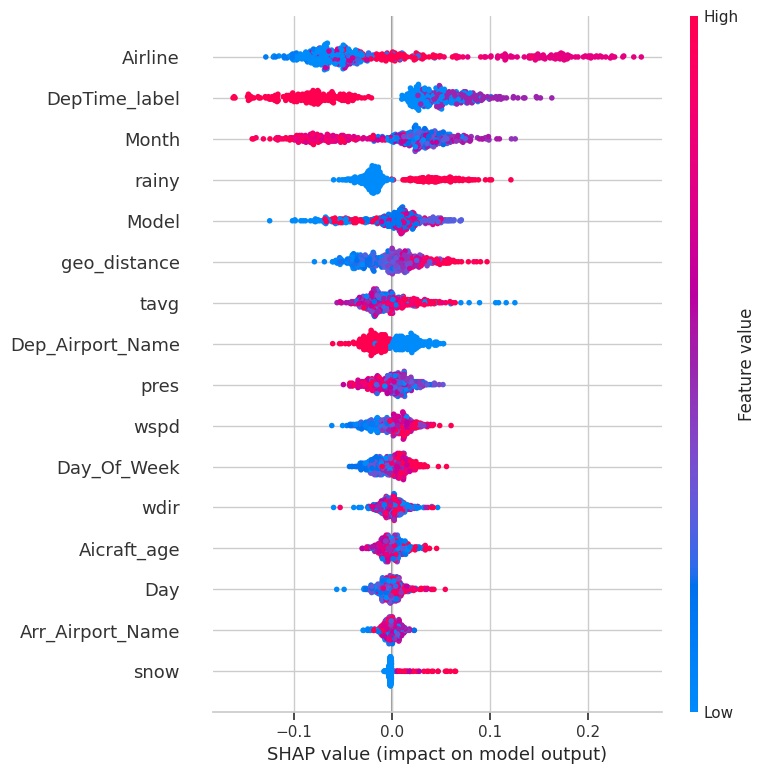

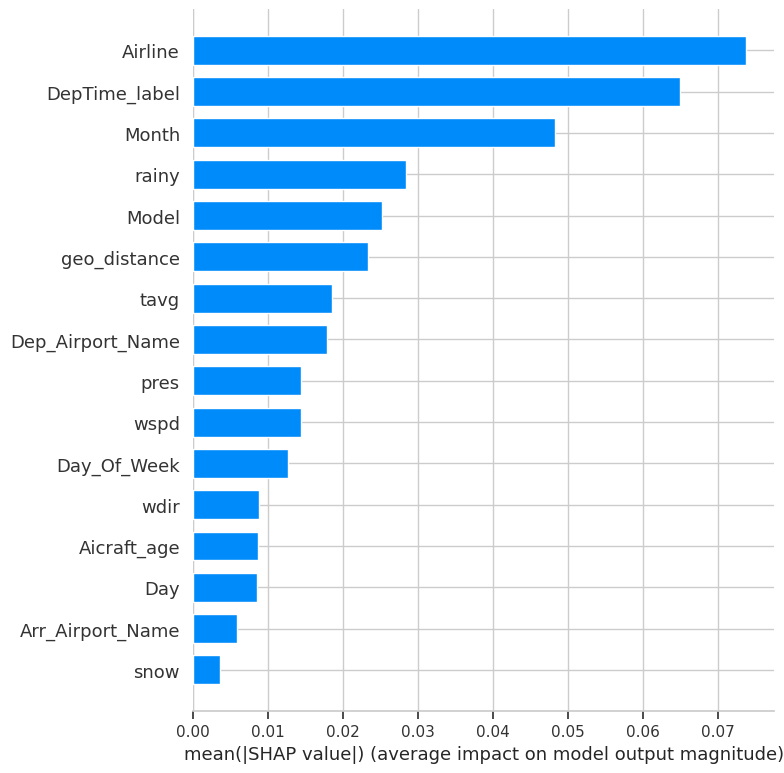

In [68]:
shap_class1 = shap_values[:, :, 1]
shap.summary_plot(shap_class1, X_test_sample)

shap.summary_plot(shap_class1, X_test_sample, plot_type="bar")


The SHAP summary plot shows the global impact of each feature on the Random Forest predictions. Features are ordered by importance, and each point represents the contribution of a feature to an individual prediction. The color encodes the feature value, allowing us to observe both the magnitude and direction of the effect.

Operational and temporal variables still dominate the explanation with **Airline**, **DepTime_label**, and **Month** having the largest impact on the model output.


### SHAP Local Explanation

For the Local Explanation we decide to use the instance number 3 (and will always be use for local explanations). This instance was correctly evaluated by the model and tell us the information about a delayed flight.

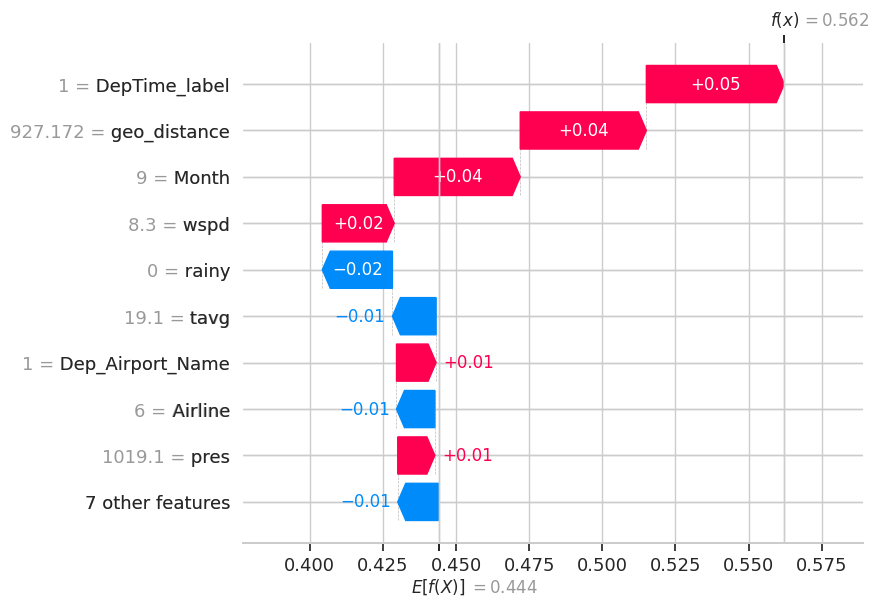

In [69]:
instance_index = 3

values = shap_values[instance_index, :, 1]

data_row = X_test.iloc[instance_index]

shap.waterfall_plot(shap.Explanation(
    values=values,
    base_values=explainer.expected_value[1],
    data=data_row,
    feature_names=X_test.columns
))


### SHAP Local Explanation 

This SHAP waterfall plot explains the prediction for a single flight instance. The model output is **f(x) = 0.562**, which is above the decision threshold, meaning that this flight is **classified as delayed**.

Starting from the baseline prediction (**E[f(X)] = 0.444**), several features push the prediction towards a higher delay probability. The most influential positive contributors are **DepTime_label**, **geo_distance**, and **Month**, indicating that the departure time category, a longer flight distance, and the specific month all increase the likelihood of delay for this flight. **Wind speed (wspd)** also contributes positively.

On the other hand, features such as **rainy**, **average temperature (tavg)**, and **Airline** slightly decrease the predicted delay probability. These negative contributions are not strong enough to counterbalance the dominant positive effects.



### LIME – Local Interpretable Model-Agnostic Explanations


In [70]:
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=["On time", "Delayed"],
    mode="classification"
)

In [71]:
i = 3 # same instance as SHAP example
exp = lime_explainer.explain_instance(
    X_test.iloc[i].values,
    rf.predict_proba,
    num_features=18,
    num_samples=10000
)

/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [72]:
print(exp.as_list())

[('0.00 < DepTime_label <= 1.00', 0.08122420704673734), ('rainy <= 0.00', -0.06194054966479361), ('Model > 13.00', 0.03661564706613465), ('7.00 < Month <= 10.00', -0.03246702685767953), ('4.00 < Airline <= 7.00', -0.030685945091377145), ('0.00 < Dep_Airport_Name <= 1.00', -0.02245495879899355), ('720.00 < geo_distance <= 1071.23', -0.013132087453929112), ('2.00 < Day_Of_Week <= 4.00', -0.009281155085150308), ('Aicraft_age <= 7.00', 0.008875086641558547), ('1015.50 < pres <= 1019.70', -0.008399342233332571), ('snow <= 0.00', -0.0076431460360302655), ('Day > 23.00', 0.007132743147759083), ('15.80 < tavg <= 21.50', -0.00649049915086433), ('6.30 < wspd <= 11.20', -0.004918722845944714), ('wdir <= 83.00', -0.004872836263673502), ('Arr_Airport_Name <= 53.00', -0.0010953479786674808)]


In [73]:
HTML(exp.as_html())

### LIME Explanation for Instance number 3

This LIME explanation corresponds to a flight predicted as **delayed**, with a predicted probability of **0.68** for the delayed class. The bars indicate how each feature contributes locally to the prediction, either increasing or decreasing the likelihood of delay.

Features such as **DepTime_label**, **Model**, **Month**, **Airline**, and **geo_distance** contribute positively to the delayed prediction, pushing the model towards the delayed class. In contrast, variables like **rainy**, **snow**, **average temperature (tavg)**, and some calendar-related features slightly reduce the delay probability.

Overall, this explanation aligns well with the SHAP local analysis, reinforcing the idea that operational and temporal factors dominate the decision, while weather-related variables play a more secondary role in this specific prediction.


In [74]:
print("Local Fidelity (R²):", exp.score)


Local Fidelity (R²): 0.1696418206529422


### Local Fidelity of LIME Explanation

The local fidelity score (R²) obtained for this instance is **0.19**, which is relatively low. This indicates that the linear surrogate used by LIME only partially approximates the behavior of the black-box model in the local neighborhood of this instance.

This result highlights an important limitation of LIME that when the underlying model exhibits strong non-linearities or complex feature interactions, a simple linear approximation may struggle to provide a highly faithful explanation. Nevertheless, LIME remains useful as a **qualitative interpretability tool**, offering insights into the main features influencing the prediction rather than an exact local replication of the model.


## Task 3.3 - Example-Based Technique

[Back to the top](#Table-of-Contents)

### Counterfactual Explanations with DiCE

Counterfactual explanations aim to identify the **smallest possible changes** to the input features that would lead to a different model prediction. In this task, we use **DiCE (Diverse Counterfactual Explanations)** to generate alternative scenarios that would flip the Random Forest’s decision.

These explanations are particularly useful from a user-centric perspective, as they answer *“what would need to change for a different outcome to occur?”*, complementing feature-based explanations by focusing on actionable and example-driven insights.


In [75]:
cat_cols = ["Airline", "DepTime_label", "Model", "Dep_Airport_Name", "Arr_Airport_Name"]

target_col= "Dep_Delay_Tag"

continuous_features = [col for col in X.columns if col not in cat_cols]

data_dice = dice_ml.Data(
    dataframe=df_encoded,
    continuous_features=continuous_features,
    outcome_name=target_col
)
model_dice = dice_ml.Model(model=rf, backend="sklearn")
dice = dice_ml.Dice(data_dice, model_dice, method="genetic")



In [76]:
y_test_pred = rf.predict(X_test)

instance_pred1 = X_test.loc[[432035]]
instance_pred0 = X_test.loc[[139973]]

print("Current proba for pred1 instance:", rf.predict_proba(instance_pred1)[0])
print("Current proba for pred0 instance:", rf.predict_proba(instance_pred0)[0])


Current proba for pred1 instance: [0.31657323 0.68342677]
Current proba for pred0 instance: [0.7753327 0.2246673]


In [77]:
features_to_vary = df_encoded.columns.tolist()

remove_these = [
    "Dep_Airport_Name",
    "Arr_Airport_Name",
    "geo_distance",
    "Month",
    "Day",
    "Day_Of_Week"
]

features_to_vary = [f for f in df_encoded.columns if f not in remove_these and f != target_col]

cf_pred1 = dice.generate_counterfactuals(
    instance_pred1,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary=features_to_vary
)

cf_pred0 = dice.generate_counterfactuals(
    instance_pred0,
    total_CFs=1,
    desired_class="opposite",
    features_to_vary=features_to_vary
)

cf_pred1.visualize_as_dataframe(show_only_changes=True)
cf_pred0.visualize_as_dataframe(show_only_changes=True)


  0%|          | 0/1 [00:00<?, ?it/s]/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/dice_ml/explainer_interfaces/dice_genetic.py:285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_instance_df_dummies[col] = 0
/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/dice_ml/explainer_interfaces/dice_genetic.py:285: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  query_instance_df_dummies[col] = 0
/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib

Query instance (original outcome : 1)


Day_Of_Week  Airline  DepTime_label  Model  Aicraft_age  tavg  snow  wdir  \
0            4        6              1     14            1  19.1   0.0  58.0   

   wspd         pres  Dep_Airport_Name  Arr_Airport_Name  geo_distance  Month  \
0   8.3  1019.099976                 1                10    927.171753      9   

   Day  rainy  Dep_Delay_Tag  
0   28      0              1


Diverse Counterfactual set (new outcome: 0)


Day_Of_Week Airline DepTime_label Model Aicraft_age tavg snow wdir wspd  \
0           -     1.0           3.0  10.0           -  6.0    -  0.0    -   

  pres Dep_Airport_Name Arr_Airport_Name geo_distance Month Day rainy  \
0    -                -                -            -     -   -     -   

  Dep_Delay_Tag  
0           0.0

Query instance (original outcome : 0)


Day_Of_Week  Airline  DepTime_label  Model  Aicraft_age  tavg  snow  wdir  \
0            7        5              1     17           16  13.9   0.0  41.0   

   wspd         pres  Dep_Airport_Name  Arr_Airport_Name  geo_distance  Month  \
0   5.8  1020.599976                 1               139     946.50177      3   

   Day  rainy  Dep_Delay_Tag  
0    5      0              0


Diverse Counterfactual set (new outcome: 1)


Day_Of_Week Airline DepTime_label Model Aicraft_age tavg snow wdir wspd  \
0           -    11.0           0.0   1.0        12.0  5.0    -  0.0    -   

  pres Dep_Airport_Name Arr_Airport_Name geo_distance Month Day rainy  \
0    -                -                -            -     -   -     -   

  Dep_Delay_Tag  
0           1.0

### Nearest Neighbors Explanations 


In [78]:
def build_cf_table(original_df, cf_result):
    cf_df = cf_result.cf_examples_list[0].final_cfs_df.copy()
    cf_df = cf_df.drop(columns=[target_col], errors="ignore")
    original = original_df.iloc[0]
    cf_row = cf_df.iloc[0]
    return pd.DataFrame({"original": original, "counterfactual": cf_row})

table_pred1 = build_cf_table(instance_pred1, cf_pred1)
table_pred0 = build_cf_table(instance_pred0, cf_pred0)

print("Counterfactual to flip Delayed -> On time (predicted 1 -> 0)")
display(table_pred1)
print("Counterfactual to flip On time -> Delayed (predicted 0 -> 1)")
display(table_pred0)


Counterfactual to flip Delayed -> On time (predicted 1 -> 0)


original  counterfactual
Day_Of_Week          4.000000          4.0000
Airline              6.000000          1.0000
DepTime_label        1.000000          3.0000
Model               14.000000         10.0000
Aicraft_age          1.000000          1.0000
tavg                19.100000          6.0000
snow                 0.000000          0.0000
wdir                58.000000          0.0000
wspd                 8.300000          8.3000
pres              1019.100000       1019.1000
Dep_Airport_Name     1.000000          1.0000
Arr_Airport_Name    10.000000         10.0000
geo_distance       927.171778        927.1718
Month                9.000000          9.0000
Day                 28.000000         28.0000
rainy                0.000000          0.0000

Counterfactual to flip On time -> Delayed (predicted 0 -> 1)


original  counterfactual
Day_Of_Week          7.000000          7.0000
Airline              5.000000         11.0000
DepTime_label        1.000000          0.0000
Model               17.000000          1.0000
Aicraft_age         16.000000         12.0000
tavg                13.900000          5.0000
snow                 0.000000          0.0000
wdir                41.000000          0.0000
wspd                 5.800000          5.8000
pres              1020.600000       1020.6000
Dep_Airport_Name     1.000000          1.0000
Arr_Airport_Name   139.000000        139.0000
geo_distance       946.501783        946.5018
Month                3.000000          3.0000
Day                  5.000000          5.0000
rainy                0.000000          0.0000

### Counterfactual Explanations (DiCE)

In the first case, the original instance is predicted as **delayed (1)**. The generated counterfactual changes mainly **operational variables**, such as **Airline**, **DepTime_label**, **Model**, and **Aircraft_age**, while keeping most contextual features fixed or unconstrained. These modifications are enough to change the prediction to **on-time (0)**, indicating that the model is highly sensitive to airline-specific and scheduling-related factors.

In the second case, the original instance is **on-time (0)**, and the counterfactual flips the prediction to **delayed (1)**. Again, the changes occur primarily in **Airline**, **DepTime_label**, and **Model**, reinforcing the idea that these features act as key decision levers for the model.

Overall, these counterfactuals highlight that **small adjustments in operational characteristics** can significantly affect the predicted delay outcome. From an explainability perspective, this supports the findings from the previous methods, which consistently identify airline and departure-time-related variables as the most influential drivers of the Random Forest’s decisions.


### Evaluation of Counterfactual Explanations

**Validity**  
This criterion is satisfied, as all generated counterfactuals successfully flip the model’s prediction to the desired target class.

**Plausibility**  
The counterfactuals are generally plausible, since core contextual attributes such as departure and arrival airports, flight distance, and calendar-related variables (day and month) are kept unchanged. This ensures that the alternative scenarios remain realistic and consistent with real-world flight operations.

**Actionability**  
Actionability is only partially satisfied. While some modified features (e.g., airline or departure time category) could be influenced at a planning or booking level, other features such as weather-related variables (e.g., rain or wind) are not directly controllable by the user. At best, these can only be anticipated through weather forecasts.

**Feasibility**  
Feasibility is satisfied, as the suggested changes fall within valid ranges observed in the dataset and do not violate known constraints of the problem domain.

### Nearest Neighbors Explanations

Nearest Neighbors explanations are an example-based interpretability technique that aims to contextualize a prediction by comparing a given instance with its most similar observations in the dataset.

This approach complements counterfactual explanations by grounding the analysis in real, observed data points, helping to assess whether a prediction is supported by similar historical cases.


In [79]:
def explain_with_neighbors(
    x_instance, 
    X_train, 
    y_train, 
    model, 
    k=3, 
    metric="euclidean"
):
    
    pred = model.predict(x_instance)[0]
    
    same_class = X_train[y_train == pred]
    
    dist = pairwise_distances(x_instance, same_class, metric=metric)[0]
    
    nearest_idx = np.argsort(dist)[:k]
    neighbors = same_class.iloc[nearest_idx]
    
    df_explan = pd.concat(
        [x_instance.assign(role="query")] + 
        [neighbors.iloc[[i]].assign(role=f"neighbor_{i+1}") for i in range(k)]
    )
    
    return df_explan, pred


In [80]:
y_pred_test = rf.predict(X_test)

sample_1 = X_test.loc[[432035]]
sample_0 = X_test.loc[[139973]]


In [81]:
exp1, pred1 = explain_with_neighbors(sample_1, X_train, y_train, rf, k=10)
print("Prediction for instance 1:", pred1)
display(exp1)


Prediction for instance 1: 1


Day_Of_Week  Airline  DepTime_label  Model  Aicraft_age  tavg  snow  \
432035            4        6              1     14            1  19.1   0.0   
432034            4        6              0     14            1  19.1   0.0   
432786            4       12              0     14            6  19.1   0.0   
484944            1        6              0     14            1  14.2   0.0   
484943            1        6              2     14            7  14.2   0.0   
218320            2        6              1     13            8  19.3   0.0   
218710            6        6              2     13            5  19.5   0.0   
218325            2        6              0     13            8  19.3   0.0   
219442            2       12              0     13            5  19.3   0.0   
537945            6        6              1     13            3   9.1   0.0   
485048            2        6              0     14            1  14.7   0.0   

        wdir  wspd    pres  Dep_Airport_Name  Arr_Airport_Name  geo_distance  \
432035  58.0   8.3  1019.1                 1                10    927.171778   
432034  58.0   8.3  1019.1                 1                10    927.171778   
432786  58.0   8.3  1019.1                 1                10    927.171778   
484944  55.0   5.6  1021.6                 1                10    927.171778   
484943  55.0   5.6  1021.6                 1                10    927.171778   
218320  61.0  13.1  1018.0                 1                10    927.171778   
218710  60.0  17.6  1018.8                 1                10    927.171778   
218325  61.0  13.1  1018.0                 1                10    927.171778   
219442  61.0  13.1  1018.0                 1                10    927.171778   
537945  62.0   9.4  1022.6                 1                10    927.171778   
485048  50.0   6.3  1025.9                 1                10    927.171778   

        Month  Day  rainy         role  
432035      9   28      0        query  
432034      9   28      0   neighbor_1  
432786      9   28      0   neighbor_2  
484944     10   23      0   neighbor_3  
484943     10   23      0   neighbor_4  
218320      5   23      1   neighbor_5  
218710      5   27      0   neighbor_6  
218325      5   23      1   neighbor_7  
219442      5   23      1   neighbor_8  
537945     11   25      0   neighbor_9  
485048     10   24      0  neighbor_10

In [82]:
exp0, pred0 = explain_with_neighbors(sample_0, X_train, y_train, rf, k=10)
print("Prediction for instance 2:", pred0)
display(exp0)


Prediction for instance 2: 0


Day_Of_Week  Airline  DepTime_label  Model  Aicraft_age  tavg  snow  \
139973            7        5              1     17           16  13.9   0.0   
140791            7        5              0     17           16  13.9   0.0   
140486            7        5              2     17           10  13.9   0.0   
191458            2        5              1     17           15  12.6   0.0   
191419            2        5              2     17           15  12.6   0.0   
48008             6        5              1     17           16   8.7   0.0   
48444             6        5              2     17           16   8.7   0.0   
459783            3        5              2     17           11  20.7   0.0   
513804            7        5              2     17           16  12.2   0.0   
459775            3        5              2     17           10  20.7   0.0   
513727            7        5              2     17           21  12.2   0.0   

        wdir  wspd    pres  Dep_Airport_Name  Arr_Airport_Name  geo_distance  \
139973  41.0   5.8  1020.6                 1               139    946.501783   
140791  41.0   5.8  1020.6                 1               139    946.501783   
140486  41.0   5.8  1020.6                 1               139    946.501783   
191458  35.0   5.0  1026.4                 1               139    946.501783   
191419  35.0   5.0  1026.4                 1               139    946.501783   
48008   39.0  14.4  1018.0                 1               139    946.501783   
48444   39.0  14.4  1018.0                 1               139    946.501783   
459783  37.0   5.0  1019.9                 1               139    946.501783   
513804  41.0   8.5  1026.3                 1               139    946.501783   
459775  37.0   5.0  1019.9                 1               139    946.501783   
513727  41.0   8.5  1026.3                 1               139    946.501783   

        Month  Day  rainy         role  
139973      3    5      0        query  
140791      3    5      0   neighbor_1  
140486      3    5      0   neighbor_2  
191458      4   11      0   neighbor_3  
191419      4   11      0   neighbor_4  
48008       2   11      1   neighbor_5  
48444       2   11      1   neighbor_6  
459783     10    4      0   neighbor_7  
513804     11   12      0   neighbor_8  
459775     10    4      0   neighbor_9  
513727     11   12      0  neighbor_10

### Nearest Neighbors Analysis – Results and Interpretation

For the first instance (predicted as **delayed**), we observe that many of the closest neighbors correspond to the same route, with very similar characteristics in terms of airline, aircraft model, departure airport, arrival airport, and flight distance. This pattern persists not only among the closest neighbors, but continues consistently across a much larger neighborhood (up to 300 nearest neighbors).

This strongly suggests that **the route itself is structurally prone to delays**, likely due to operational factors captured indirectly by features such as airline, departure time category, and aircraft model.

For the second instance (predicted as *on-time*), a similar behavior is observed: its nearest neighbors share highly comparable operational and contextual features, and the majority of them also result in **on-time arrivals**. This consistency reinforces the model’s decision and increases trust in the prediction.


# Task 4: Quality of Explanations

[Back to the top](#Table-of-Contents)

Even if explanations appear intuitive, they must be **quantitatively evaluated** to ensure their reliability and faithfulness to the underlying model. In this final task, we assess the quality of the generated explanations by using formal **XAI evaluation metrics**.

More specifically, we focus on **comprehensiveness** and **sufficiency**, two complementary criteria that evaluate how well the most important features identified by the explanation method capture the model’s decision process. These metrics allow us to measure whether the explanations truly reflect the behavior of the black-box model, rather than being merely plausible narratives.

For this evaluation, we rely on **SHAP-based explanations**, as SHAP provides more stable and consistent feature attributions. In contrast, LIME explanations are highly local and exhibit lower fidelity in our setting, which makes them less suitable for quantitative quality assessment.


In [83]:
def comprehensiveness(model, x, shap_vals, X_train, k):
    top_k_idx = np.argsort(np.abs(shap_vals))[::-1][:k]

    original_pred = model.predict_proba(x.reshape(1, -1))[0][1]

    x_masked = x.copy()
    x_masked[top_k_idx] = X_train.mean().values[top_k_idx]

    new_pred = model.predict_proba(x_masked.reshape(1, -1))[0][1]

    return original_pred - new_pred, original_pred, new_pred

i = 3
x = X_test_sample.iloc[i].values
shap_vals = shap_values[i, :, 1]

comp_score, orig, new = comprehensiveness(rf, x, shap_vals, X_train, k=5)

print("Original prediction:", orig)
print("Prediction after removing top-5 features:", new)
print("Comprehensiveness score:", comp_score)


Original prediction: 0.5622015338290776
Prediction after removing top-5 features: 0.6239437720860902
Comprehensiveness score: -0.06174223825701264


/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [84]:
def sufficiency(model, x, shap_vals, k=5):
    top_k_idx = np.argsort(np.abs(shap_vals))[::-1][:k]

    x_sufficient = np.zeros_like(x)
    x_sufficient[top_k_idx] = x[top_k_idx]

    pred_sufficient = model.predict_proba(x_sufficient.reshape(1, -1))[0][1]
    full_pred = model.predict_proba(x.reshape(1, -1))[0][1]

    return pred_sufficient, full_pred

suff, full = sufficiency(rf, x, shap_vals, k=5)

print("Sufficient-only prediction:", suff)
print("Full model prediction:", full)



Sufficient-only prediction: 0.3931124409307429
Full model prediction: 0.5622015338290776


/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/rodrigobatista/PycharmProjects/4ano/1semestre/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


### Comprehensiveness and Sufficiency – Results Interpretation

For **comprehensiveness**, we compare the original prediction with the prediction obtained after removing the top-5 most important features identified by the explanation method. The prediction increases from **0.562 to 0.624**, resulting in a **comprehensiveness score of -0.062**.  
This relatively small change indicates that, although the selected features contribute to the decision, removing them does not drastically alter the model’s output. This suggests that the Random Forest distributes information across multiple features rather than relying on a very small subset.

For **sufficiency**, we evaluate whether the top-5 features alone are enough to reproduce the original prediction. Using only these features leads to a prediction of **0.393**, compared to **0.562** from the full model. The noticeable difference shows that the selected features are **not sufficient on their own** to fully explain the model’s decision, and that additional contextual features play an important role.

Overall, these results suggest that the explanations capture **relevant but not exhaustive information**: the identified features are meaningful, yet the model’s behavior depends on a broader combination of variables. This aligns with the nature of ensemble models such as Random Forests, which tend to spread importance across multiple interacting features.


# Conclusion

[Back to the top](#Table-of-Contents)

This study compared multiple explainable AI techniques for flight delay prediction using a structured pre-modelling, in-modelling, and post-modelling workflow. Pre-modelling analysis revealed that delays arise from complex, non-linear interactions between operational, temporal, and weather-related factors. An interpretable Decision Tree provided transparent but limited explanations, while a Random Forest improved performance at the cost of interpretability. Post-hoc methods showed complementary strengths: SHAP offered stable explanations, LIME provided intuitive but less faithful local insights, and surrogate and counterfactual approaches added global and actionable perspectives. Overall, the results confirm that no single XAI method is sufficient, and that combining multiple approaches is necessary to reliably interpret complex models.